In [1]:
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import cvxpy as cvx
from scipy.stats import norm
from numpy.linalg import inv
import math

import keras
import seaborn as sns
import sklearn
import tensorflow as tf

# for plotting
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import matplotlib.pyplot as plt

# Initialize plotly offline
plotly.offline.init_notebook_mode(connected=True)

from benchmarks import *

Using TensorFlow backend.


## Normalization

In [2]:
def normalized(data):
    data_temp = data - np.mean(data)
    variance = np.sum(data ** 2)/len(data)
    data_temp /= variance
    return data_temp

## Load stock data

### US Stocks

In [3]:
us_stocks = ['SPY', # The SP500 as a benchmark
             'AAPL', 'MMM', 'BA' , 'CAT', 'CVX' , 'CSCO', 'KO' , 'DIS',
             'GS', 'IBM', 'INTC', 'JNJ', 'JPM', 'MSFT', 'PFE'] #Some stocks from the Dow Jones

start_data = '2008-09-01'
end_date = '2008-10-01'

In [4]:
# download_stock_data(start_data, end_date, us_stocks, 'us_stocks_latest')

In [5]:
# read in the data again
us_stock_prices = pd.read_csv('./00_Data/us_stocks_latest.csv', header=0, index_col = 0)
us_stock_prices.index = pd.to_datetime(us_stock_prices.index)

#Process Stock Data
us_stock_relative_prices, us_stock_returns = process_stock_data(us_stock_prices)

# Extract benchmark SP500 Data
SPY_relative_price_benchmark = us_stock_relative_prices.drop(us_stocks[1:], axis=1)
SPY_returns_benchmark = us_stock_returns.drop(us_stocks[1:], axis=1)
us_stock_prices_norm_wo_SPY = us_stock_relative_prices.drop(us_stocks[0], axis=1)

# filter out benchmark data from stock returns
us_stock_returns = us_stock_returns.drop(us_stocks[0], axis=1)

### Hundred stocks

In [6]:
# Read in the data
hundred_stock_prices = pd.read_csv('./00_Data/hundred_stocks.csv', header=0, index_col = 0)

In [7]:
hundred_stock_prices.index = pd.to_datetime(hundred_stock_prices.index)

#Process Stock Data
# hundred_stock_relative_prices, hundred_stock_returns = process_stock_data(hundred_stock_prices)

#Read processed data to save time
hundred_stock_relative_prices = pd.read_csv('./00_Data/hundred_stock_relative_prices.csv', header=0, index_col = 0)
hundred_stock_returns = pd.read_csv('./00_Data/hundred_stock_returns.csv', header=0, index_col = 0)

#### SPY

In [8]:
# download_stock_data('2001-01-02', '2019-07-17', ['SPY'], 'SPY_same_dates_as_hundred_stocks')

In [9]:
# Read in the data
SPY_prices = pd.read_csv('./00_Data/SPY_same_dates_as_hundred_stocks.csv', header=0, index_col = 0)

In [10]:
SPY_prices.index = pd.to_datetime(hundred_stock_prices.index)

#Process Stock Data
SPY_relative_prices, SPY_returns = process_stock_data(SPY_prices)

### Subprime mortgage crisis period data

In [11]:
subprime_mortgage_crisis = hundred_stock_prices.loc['2008-09'].dropna(axis=1) 
SPMC_relative_prices, SPMC_returns = process_stock_data(subprime_mortgage_crisis) # H_i,t of each asset i for t = 1,...,20

In [12]:
SPMC_SPY_relative_price_benchmark = SPY_relative_price_benchmark.loc['2008-09']

In [38]:
SPMC_returns = SPMC_returns.iloc[1:]

# Directions: Deep portfolio using neural network

Next we are to implement the deep portfolio. Recall the four step procedure: 
- **Auto-encoding**: this phase is essentially dimension reduction. *In the paper: one hidden layer with five neurons*.
- **Calibration**: using the stock price of the first few years, our target index $Y$ is the S&P500 (we can also play with this target so that the portfolio map can possibly outperform S&P500 -- but this is for later). *In the paper: ReLU and 4-fold cross validation*. 
- **Validation**: out-sample validation. Will need to test with different number of stocks.
- **Verification**: deep frontier. We look at the 2-norm out-of-sample error for different number of stocks used.

## 1. Auto-encoding

**Used Data**: 
- SPMC_returns: 20 daily returns during September of 2008 calculated with hundred_stocks.

**NN Model**: 
- 87 - 5 - 87

In [60]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.001)

# Import `Dense` from `keras.layers`
from keras.layers import Dense

### Constructing model

In [61]:
# Initialize the constructor
autoencoder_model = Sequential()

#input 87 stock data, and the hidden layer has 5 neurons; no biased involved (unless we let use_bias = TRUE)
autoencoder_model.add(Dense(units = 5, input_dim = 87, use_bias = False))
autoencoder_model.add(LeakyReLU(alpha=0.05))
autoencoder_model.add(Dense(units = 87, use_bias = False))
autoencoder_model.add(LeakyReLU(alpha=0.05))

### Set optimizer and learning rate

In [62]:
# autoencoder_opt = RMSprop(lr=0.001)

### Compile & Learn

In [63]:
autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [70]:
autoencoder_model.fit(SPMC_returns, SPMC_returns, epochs = 10000)

Epoch 1/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5174e-04 - mean_absolute_error: 0.0190
Epoch 2/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5184e-04 - mean_absolute_error: 0.0189
Epoch 3/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5181e-04 - mean_absolute_error: 0.0190
Epoch 4/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5166e-04 - mean_absolute_error: 0.0189
Epoch 5/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5145e-04 - mean_absolute_error: 0.0190
Epoch 6/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5125e-04 - mean_absolute_error: 0.0189
Epoch 7/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5115e-04 - mean_absolute_error: 0.0189
Epoch 8/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5116e-04 - mean_absolute_error: 0.0189
Epoch 9/10000
20/20 [==============================] - 0s 84us/s

Epoch 71/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5319e-04 - mean_absolute_error: 0.0190
Epoch 72/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5406e-04 - mean_absolute_error: 0.0191
Epoch 73/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5527e-04 - mean_absolute_error: 0.0191
Epoch 74/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5693e-04 - mean_absolute_error: 0.0192
Epoch 75/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5914e-04 - mean_absolute_error: 0.0193
Epoch 76/10000
20/20 [==============================] - 0s 77us/step - loss: 7.6197e-04 - mean_absolute_error: 0.0194
Epoch 77/10000
20/20 [==============================] - 0s 65us/step - loss: 7.6534e-04 - mean_absolute_error: 0.0194
Epoch 78/10000
20/20 [==============================] - 0s 66us/step - loss: 7.6893e-04 - mean_absolute_error: 0.0196
Epoch 79/10000
20/20 [==============================] - 

20/20 [==============================] - 0s 77us/step - loss: 7.5106e-04 - mean_absolute_error: 0.0189
Epoch 141/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5104e-04 - mean_absolute_error: 0.0189
Epoch 142/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 143/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5102e-04 - mean_absolute_error: 0.0189
Epoch 144/10000
20/20 [==============================] - 0s 46us/step - loss: 7.5102e-04 - mean_absolute_error: 0.0189
Epoch 145/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5102e-04 - mean_absolute_error: 0.0189
Epoch 146/10000
20/20 [==============================] - 0s 53us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 147/10000
20/20 [==============================] - 0s 43us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 148/10000
20/20 [==============================] - 0s 58us

Epoch 209/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5190e-04 - mean_absolute_error: 0.0190
Epoch 210/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5238e-04 - mean_absolute_error: 0.0190
Epoch 211/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5250e-04 - mean_absolute_error: 0.0190
Epoch 212/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5223e-04 - mean_absolute_error: 0.0190
Epoch 213/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5173e-04 - mean_absolute_error: 0.0190
Epoch 214/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5127e-04 - mean_absolute_error: 0.0189
Epoch 215/10000
20/20 [==============================] - 0s 128us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 216/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5108e-04 - mean_absolute_error: 0.0189
Epoch 217/10000
20/20 [========================

Epoch 278/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5257e-04 - mean_absolute_error: 0.0190
Epoch 279/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5324e-04 - mean_absolute_error: 0.0191
Epoch 280/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5421e-04 - mean_absolute_error: 0.0191
Epoch 281/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5557e-04 - mean_absolute_error: 0.0192
Epoch 282/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5744e-04 - mean_absolute_error: 0.0192
Epoch 283/10000
20/20 [==============================] - 0s 114us/step - loss: 7.5994e-04 - mean_absolute_error: 0.0193
Epoch 284/10000
20/20 [==============================] - 0s 77us/step - loss: 7.6307e-04 - mean_absolute_error: 0.0193
Epoch 285/10000
20/20 [==============================] - 0s 63us/step - loss: 7.6664e-04 - mean_absolute_error: 0.0195
Epoch 286/10000
20/20 [========================

Epoch 347/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5099e-04 - mean_absolute_error: 0.0189
Epoch 348/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5099e-04 - mean_absolute_error: 0.0189
Epoch 349/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5099e-04 - mean_absolute_error: 0.0189
Epoch 350/10000
20/20 [==============================] - 0s 94us/step - loss: 7.5100e-04 - mean_absolute_error: 0.0189
Epoch 351/10000
20/20 [==============================] - 0s 108us/step - loss: 7.5101e-04 - mean_absolute_error: 0.0189
Epoch 352/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5102e-04 - mean_absolute_error: 0.0189
Epoch 353/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5102e-04 - mean_absolute_error: 0.0189
Epoch 354/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5102e-04 - mean_absolute_error: 0.0189
Epoch 355/10000
20/20 [========================

Epoch 416/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5139e-04 - mean_absolute_error: 0.0190
Epoch 417/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5132e-04 - mean_absolute_error: 0.0189
Epoch 418/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5157e-04 - mean_absolute_error: 0.0190
Epoch 419/10000
20/20 [==============================] - 0s 142us/step - loss: 7.5193e-04 - mean_absolute_error: 0.0189
Epoch 420/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5216e-04 - mean_absolute_error: 0.0190
Epoch 421/10000
20/20 [==============================] - 0s 112us/step - loss: 7.5213e-04 - mean_absolute_error: 0.0190
Epoch 422/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5186e-04 - mean_absolute_error: 0.0190
Epoch 423/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5147e-04 - mean_absolute_error: 0.0189
Epoch 424/10000
20/20 [======================

Epoch 485/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5119e-04 - mean_absolute_error: 0.0189
Epoch 486/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5128e-04 - mean_absolute_error: 0.0189
Epoch 487/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5141e-04 - mean_absolute_error: 0.0190
Epoch 488/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5159e-04 - mean_absolute_error: 0.0189
Epoch 489/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5186e-04 - mean_absolute_error: 0.0190
Epoch 490/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5225e-04 - mean_absolute_error: 0.0190
Epoch 491/10000
20/20 [==============================] - 0s 54us/step - loss: 7.5281e-04 - mean_absolute_error: 0.0191
Epoch 492/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5361e-04 - mean_absolute_error: 0.0190
Epoch 493/10000
20/20 [========================

Epoch 554/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5105e-04 - mean_absolute_error: 0.0189
Epoch 555/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5105e-04 - mean_absolute_error: 0.0189
Epoch 556/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 557/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5100e-04 - mean_absolute_error: 0.0189
Epoch 558/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5098e-04 - mean_absolute_error: 0.0189
Epoch 559/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5097e-04 - mean_absolute_error: 0.0189
Epoch 560/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5097e-04 - mean_absolute_error: 0.0189
Epoch 561/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5098e-04 - mean_absolute_error: 0.0189
Epoch 562/10000
20/20 [=========================

Epoch 623/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5132e-04 - mean_absolute_error: 0.0189
Epoch 624/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5137e-04 - mean_absolute_error: 0.0189
Epoch 625/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5146e-04 - mean_absolute_error: 0.0190
Epoch 626/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5150e-04 - mean_absolute_error: 0.0189
Epoch 627/10000
20/20 [==============================] - 0s 110us/step - loss: 7.5146e-04 - mean_absolute_error: 0.0190
Epoch 628/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5133e-04 - mean_absolute_error: 0.0189
Epoch 629/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5117e-04 - mean_absolute_error: 0.0189
Epoch 630/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5106e-04 - mean_absolute_error: 0.0189
Epoch 631/10000
20/20 [=======================

Epoch 692/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5095e-04 - mean_absolute_error: 0.0189
Epoch 693/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5096e-04 - mean_absolute_error: 0.0189
Epoch 694/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5096e-04 - mean_absolute_error: 0.0189
Epoch 695/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5098e-04 - mean_absolute_error: 0.0189
Epoch 696/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5099e-04 - mean_absolute_error: 0.0189
Epoch 697/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5101e-04 - mean_absolute_error: 0.0189
Epoch 698/10000
20/20 [==============================] - 0s 111us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 699/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5106e-04 - mean_absolute_error: 0.0189
Epoch 700/10000
20/20 [=====================

Epoch 761/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5105e-04 - mean_absolute_error: 0.0189
Epoch 762/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5109e-04 - mean_absolute_error: 0.0189
Epoch 763/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5110e-04 - mean_absolute_error: 0.0189
Epoch 764/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5107e-04 - mean_absolute_error: 0.0189
Epoch 765/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5101e-04 - mean_absolute_error: 0.0189
Epoch 766/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5095e-04 - mean_absolute_error: 0.0189
Epoch 767/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 768/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 769/10000
20/20 [=========================

Epoch 830/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5189e-04 - mean_absolute_error: 0.0190
Epoch 831/10000
20/20 [==============================] - 0s 108us/step - loss: 7.5226e-04 - mean_absolute_error: 0.0190
Epoch 832/10000
20/20 [==============================] - 0s 114us/step - loss: 7.5247e-04 - mean_absolute_error: 0.0191
Epoch 833/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5243e-04 - mean_absolute_error: 0.0190
Epoch 834/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5218e-04 - mean_absolute_error: 0.0190
Epoch 835/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5187e-04 - mean_absolute_error: 0.0190
Epoch 836/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5161e-04 - mean_absolute_error: 0.0190
Epoch 837/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5147e-04 - mean_absolute_error: 0.0190
Epoch 838/10000
20/20 [=======================

Epoch 899/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5105e-04 - mean_absolute_error: 0.0189
Epoch 900/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5109e-04 - mean_absolute_error: 0.0189
Epoch 901/10000
20/20 [==============================] - 0s 53us/step - loss: 7.5114e-04 - mean_absolute_error: 0.0189
Epoch 902/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5122e-04 - mean_absolute_error: 0.0189
Epoch 903/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5132e-04 - mean_absolute_error: 0.0189
Epoch 904/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5146e-04 - mean_absolute_error: 0.0190
Epoch 905/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5166e-04 - mean_absolute_error: 0.0190
Epoch 906/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5193e-04 - mean_absolute_error: 0.0190
Epoch 907/10000
20/20 [=========================

Epoch 968/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5099e-04 - mean_absolute_error: 0.0189
Epoch 969/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5100e-04 - mean_absolute_error: 0.0189
Epoch 970/10000
20/20 [==============================] - 0s 94us/step - loss: 7.5099e-04 - mean_absolute_error: 0.0189
Epoch 971/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5097e-04 - mean_absolute_error: 0.0189
Epoch 972/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5094e-04 - mean_absolute_error: 0.0189
Epoch 973/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5091e-04 - mean_absolute_error: 0.0189
Epoch 974/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5090e-04 - mean_absolute_error: 0.0189
Epoch 975/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5089e-04 - mean_absolute_error: 0.0189
Epoch 976/10000
20/20 [=========================

Epoch 1037/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5126e-04 - mean_absolute_error: 0.0189
Epoch 1038/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5213e-04 - mean_absolute_error: 0.0190
Epoch 1039/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5293e-04 - mean_absolute_error: 0.0190
Epoch 1040/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5308e-04 - mean_absolute_error: 0.0191
Epoch 1041/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5252e-04 - mean_absolute_error: 0.0190
Epoch 1042/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5166e-04 - mean_absolute_error: 0.0190
Epoch 1043/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 1044/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 1045/10000
20/20 [================

20/20 [==============================] - 0s 79us/step - loss: 7.5088e-04 - mean_absolute_error: 0.0189
Epoch 1106/10000
20/20 [==============================] - 0s 138us/step - loss: 7.5088e-04 - mean_absolute_error: 0.0189
Epoch 1107/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5088e-04 - mean_absolute_error: 0.0189
Epoch 1108/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5089e-04 - mean_absolute_error: 0.0189
Epoch 1109/10000
20/20 [==============================] - 0s 133us/step - loss: 7.5090e-04 - mean_absolute_error: 0.0189
Epoch 1110/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5090e-04 - mean_absolute_error: 0.0189
Epoch 1111/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 1112/10000
20/20 [==============================] - 0s 127us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0189
Epoch 1113/10000
20/20 [=============================

Epoch 1174/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5114e-04 - mean_absolute_error: 0.0189
Epoch 1175/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5111e-04 - mean_absolute_error: 0.0189
Epoch 1176/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 1177/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5094e-04 - mean_absolute_error: 0.0189
Epoch 1178/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5088e-04 - mean_absolute_error: 0.0189
Epoch 1179/10000
20/20 [==============================] - 0s 117us/step - loss: 7.5087e-04 - mean_absolute_error: 0.0189
Epoch 1180/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5090e-04 - mean_absolute_error: 0.0189
Epoch 1181/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0189
Epoch 1182/10000
20/20 [=============

20/20 [==============================] - 0s 102us/step - loss: 7.6099e-04 - mean_absolute_error: 0.0194
Epoch 1243/10000
20/20 [==============================] - 0s 94us/step - loss: 7.6434e-04 - mean_absolute_error: 0.0195
Epoch 1244/10000
20/20 [==============================] - 0s 139us/step - loss: 7.6806e-04 - mean_absolute_error: 0.0197
Epoch 1245/10000
20/20 [==============================] - 0s 93us/step - loss: 7.7160e-04 - mean_absolute_error: 0.0197
Epoch 1246/10000
20/20 [==============================] - 0s 79us/step - loss: 7.7387e-04 - mean_absolute_error: 0.0198
Epoch 1247/10000
20/20 [==============================] - 0s 101us/step - loss: 7.7377e-04 - mean_absolute_error: 0.0198
Epoch 1248/10000
20/20 [==============================] - 0s 75us/step - loss: 7.7053e-04 - mean_absolute_error: 0.0197
Epoch 1249/10000
20/20 [==============================] - 0s 90us/step - loss: 7.6476e-04 - mean_absolute_error: 0.0195
Epoch 1250/10000
20/20 [==============================

Epoch 1311/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5086e-04 - mean_absolute_error: 0.0189
Epoch 1312/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5085e-04 - mean_absolute_error: 0.0189
Epoch 1313/10000
20/20 [==============================] - 0s 130us/step - loss: 7.5084e-04 - mean_absolute_error: 0.0189
Epoch 1314/10000
20/20 [==============================] - 0s 124us/step - loss: 7.5084e-04 - mean_absolute_error: 0.0189
Epoch 1315/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5084e-04 - mean_absolute_error: 0.0189
Epoch 1316/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5085e-04 - mean_absolute_error: 0.0189
Epoch 1317/10000
20/20 [==============================] - 0s 134us/step - loss: 7.5085e-04 - mean_absolute_error: 0.0189
Epoch 1318/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5086e-04 - mean_absolute_error: 0.0189
Epoch 1319/10000
20/20 [===========

20/20 [==============================] - 0s 99us/step - loss: 7.5366e-04 - mean_absolute_error: 0.0191
Epoch 1380/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5257e-04 - mean_absolute_error: 0.0190
Epoch 1381/10000
20/20 [==============================] - 0s 110us/step - loss: 7.5159e-04 - mean_absolute_error: 0.0190
Epoch 1382/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5114e-04 - mean_absolute_error: 0.0189
Epoch 1383/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5127e-04 - mean_absolute_error: 0.0189
Epoch 1384/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5169e-04 - mean_absolute_error: 0.0190
Epoch 1385/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5201e-04 - mean_absolute_error: 0.0190
Epoch 1386/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5200e-04 - mean_absolute_error: 0.0190
Epoch 1387/10000
20/20 [==============================]

Epoch 1448/10000
20/20 [==============================] - 0s 125us/step - loss: 7.5676e-04 - mean_absolute_error: 0.0193
Epoch 1449/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5351e-04 - mean_absolute_error: 0.0191
Epoch 1450/10000
20/20 [==============================] - 0s 131us/step - loss: 7.5151e-04 - mean_absolute_error: 0.0190
Epoch 1451/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5101e-04 - mean_absolute_error: 0.0189
Epoch 1452/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5173e-04 - mean_absolute_error: 0.0190
Epoch 1453/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5308e-04 - mean_absolute_error: 0.0191
Epoch 1454/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5438e-04 - mean_absolute_error: 0.0192
Epoch 1455/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5513e-04 - mean_absolute_error: 0.0192
Epoch 1456/10000
20/20 [============

20/20 [==============================] - 0s 71us/step - loss: 7.5085e-04 - mean_absolute_error: 0.0189
Epoch 1517/10000
20/20 [==============================] - 0s 133us/step - loss: 7.5085e-04 - mean_absolute_error: 0.0189
Epoch 1518/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5086e-04 - mean_absolute_error: 0.0189
Epoch 1519/10000
20/20 [==============================] - 0s 104us/step - loss: 7.5086e-04 - mean_absolute_error: 0.0189
Epoch 1520/10000
20/20 [==============================] - 0s 151us/step - loss: 7.5086e-04 - mean_absolute_error: 0.0189
Epoch 1521/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5087e-04 - mean_absolute_error: 0.0189
Epoch 1522/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5087e-04 - mean_absolute_error: 0.0189
Epoch 1523/10000
20/20 [==============================] - 0s 128us/step - loss: 7.5088e-04 - mean_absolute_error: 0.0189
Epoch 1524/10000
20/20 [=============================

Epoch 1585/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5118e-04 - mean_absolute_error: 0.0189
Epoch 1586/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5105e-04 - mean_absolute_error: 0.0189
Epoch 1587/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 1588/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5083e-04 - mean_absolute_error: 0.0189
Epoch 1589/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5081e-04 - mean_absolute_error: 0.0189
Epoch 1590/10000
20/20 [==============================] - 0s 43us/step - loss: 7.5085e-04 - mean_absolute_error: 0.0189
Epoch 1591/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5091e-04 - mean_absolute_error: 0.0189
Epoch 1592/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5097e-04 - mean_absolute_error: 0.0189
Epoch 1593/10000
20/20 [================

Epoch 1654/10000
20/20 [==============================] - 0s 108us/step - loss: 7.5266e-04 - mean_absolute_error: 0.0190
Epoch 1655/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5231e-04 - mean_absolute_error: 0.0190
Epoch 1656/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5175e-04 - mean_absolute_error: 0.0190
Epoch 1657/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5122e-04 - mean_absolute_error: 0.0190
Epoch 1658/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 1659/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5091e-04 - mean_absolute_error: 0.0189
Epoch 1660/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5114e-04 - mean_absolute_error: 0.0189
Epoch 1661/10000
20/20 [==============================] - 0s 178us/step - loss: 7.5143e-04 - mean_absolute_error: 0.0189
Epoch 1662/10000
20/20 [==============

Epoch 1723/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5827e-04 - mean_absolute_error: 0.0193
Epoch 1724/10000
20/20 [==============================] - 0s 56us/step - loss: 7.6127e-04 - mean_absolute_error: 0.0193
Epoch 1725/10000
20/20 [==============================] - 0s 56us/step - loss: 7.6506e-04 - mean_absolute_error: 0.0195
Epoch 1726/10000
20/20 [==============================] - 0s 82us/step - loss: 7.6945e-04 - mean_absolute_error: 0.0196
Epoch 1727/10000
20/20 [==============================] - 0s 95us/step - loss: 7.7376e-04 - mean_absolute_error: 0.0198
Epoch 1728/10000
20/20 [==============================] - 0s 68us/step - loss: 7.7677e-04 - mean_absolute_error: 0.0198
Epoch 1729/10000
20/20 [==============================] - 0s 111us/step - loss: 7.7700e-04 - mean_absolute_error: 0.0199
Epoch 1730/10000
20/20 [==============================] - 0s 87us/step - loss: 7.7353e-04 - mean_absolute_error: 0.0197
Epoch 1731/10000
20/20 [===============

Epoch 1792/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5081e-04 - mean_absolute_error: 0.0189
Epoch 1793/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5080e-04 - mean_absolute_error: 0.0189
Epoch 1794/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5079e-04 - mean_absolute_error: 0.0189
Epoch 1795/10000
20/20 [==============================] - 0s 106us/step - loss: 7.5079e-04 - mean_absolute_error: 0.0189
Epoch 1796/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0189
Epoch 1797/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5079e-04 - mean_absolute_error: 0.0189
Epoch 1798/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5079e-04 - mean_absolute_error: 0.0189
Epoch 1799/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5080e-04 - mean_absolute_error: 0.0189
Epoch 1800/10000
20/20 [==============

Epoch 1861/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5364e-04 - mean_absolute_error: 0.0191
Epoch 1862/10000
20/20 [==============================] - 0s 187us/step - loss: 7.5172e-04 - mean_absolute_error: 0.0190
Epoch 1863/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5171e-04 - mean_absolute_error: 0.0189
Epoch 1864/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5308e-04 - mean_absolute_error: 0.0191
Epoch 1865/10000
20/20 [==============================] - 0s 110us/step - loss: 7.5452e-04 - mean_absolute_error: 0.0191
Epoch 1866/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5490e-04 - mean_absolute_error: 0.0192
Epoch 1867/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5397e-04 - mean_absolute_error: 0.0191
Epoch 1868/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5238e-04 - mean_absolute_error: 0.0191
Epoch 1869/10000
20/20 [==============

20/20 [==============================] - 0s 79us/step - loss: 7.5077e-04 - mean_absolute_error: 0.0189
Epoch 1930/10000
20/20 [==============================] - 0s 136us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0189
Epoch 1931/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0189
Epoch 1932/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5079e-04 - mean_absolute_error: 0.0189
Epoch 1933/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5079e-04 - mean_absolute_error: 0.0189
Epoch 1934/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5079e-04 - mean_absolute_error: 0.0189
Epoch 1935/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5080e-04 - mean_absolute_error: 0.0189
Epoch 1936/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5081e-04 - mean_absolute_error: 0.0189
Epoch 1937/10000
20/20 [==============================]

Epoch 1998/10000
20/20 [==============================] - 0s 122us/step - loss: 7.5087e-04 - mean_absolute_error: 0.0189
Epoch 1999/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5087e-04 - mean_absolute_error: 0.0189
Epoch 2000/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5091e-04 - mean_absolute_error: 0.0189
Epoch 2001/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5095e-04 - mean_absolute_error: 0.0189
Epoch 2002/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5096e-04 - mean_absolute_error: 0.0189
Epoch 2003/10000
20/20 [==============================] - 0s 151us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0189
Epoch 2004/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5087e-04 - mean_absolute_error: 0.0189
Epoch 2005/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5081e-04 - mean_absolute_error: 0.0189
Epoch 2006/10000
20/20 [==============

20/20 [==============================] - 0s 80us/step - loss: 7.5668e-04 - mean_absolute_error: 0.0192
Epoch 2067/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5894e-04 - mean_absolute_error: 0.0194
Epoch 2068/10000
20/20 [==============================] - 0s 81us/step - loss: 7.6187e-04 - mean_absolute_error: 0.0194
Epoch 2069/10000
20/20 [==============================] - 0s 84us/step - loss: 7.6539e-04 - mean_absolute_error: 0.0196
Epoch 2070/10000
20/20 [==============================] - 0s 80us/step - loss: 7.6920e-04 - mean_absolute_error: 0.0197
Epoch 2071/10000
20/20 [==============================] - 0s 78us/step - loss: 7.7252e-04 - mean_absolute_error: 0.0198
Epoch 2072/10000
20/20 [==============================] - 0s 74us/step - loss: 7.7431e-04 - mean_absolute_error: 0.0198
Epoch 2073/10000
20/20 [==============================] - 0s 67us/step - loss: 7.7335e-04 - mean_absolute_error: 0.0198
Epoch 2074/10000
20/20 [==============================] -

Epoch 2135/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0189
Epoch 2136/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5077e-04 - mean_absolute_error: 0.0189
Epoch 2137/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5076e-04 - mean_absolute_error: 0.0189
Epoch 2138/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0189
Epoch 2139/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0189
Epoch 2140/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0189
Epoch 2141/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0189
Epoch 2142/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5076e-04 - mean_absolute_error: 0.0189
Epoch 2143/10000
20/20 [===============

Epoch 2204/10000
20/20 [==============================] - 0s 165us/step - loss: 7.5156e-04 - mean_absolute_error: 0.0190
Epoch 2205/10000
20/20 [==============================] - 0s 118us/step - loss: 7.5174e-04 - mean_absolute_error: 0.0189
Epoch 2206/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5165e-04 - mean_absolute_error: 0.0190
Epoch 2207/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5135e-04 - mean_absolute_error: 0.0189
Epoch 2208/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0189
Epoch 2209/10000
20/20 [==============================] - 0s 116us/step - loss: 7.5083e-04 - mean_absolute_error: 0.0189
Epoch 2210/10000
20/20 [==============================] - 0s 104us/step - loss: 7.5084e-04 - mean_absolute_error: 0.0189
Epoch 2211/10000
20/20 [==============================] - 0s 125us/step - loss: 7.5100e-04 - mean_absolute_error: 0.0189
Epoch 2212/10000
20/20 [===========

20/20 [==============================] - 0s 98us/step - loss: 7.8129e-04 - mean_absolute_error: 0.0200
Epoch 2273/10000
20/20 [==============================] - 0s 153us/step - loss: 7.8741e-04 - mean_absolute_error: 0.0202
Epoch 2274/10000
20/20 [==============================] - 0s 83us/step - loss: 7.8895e-04 - mean_absolute_error: 0.0202
Epoch 2275/10000
20/20 [==============================] - 0s 104us/step - loss: 7.8328e-04 - mean_absolute_error: 0.0201
Epoch 2276/10000
20/20 [==============================] - 0s 108us/step - loss: 7.7160e-04 - mean_absolute_error: 0.0197
Epoch 2277/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5928e-04 - mean_absolute_error: 0.0193
Epoch 2278/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5248e-04 - mean_absolute_error: 0.0190
Epoch 2279/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5333e-04 - mean_absolute_error: 0.0190
Epoch 2280/10000
20/20 [==============================

Epoch 2341/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0189
Epoch 2342/10000
20/20 [==============================] - 0s 129us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0189
Epoch 2343/10000
20/20 [==============================] - 0s 118us/step - loss: 7.5074e-04 - mean_absolute_error: 0.0189
Epoch 2344/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5073e-04 - mean_absolute_error: 0.0189
Epoch 2345/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5072e-04 - mean_absolute_error: 0.0189
Epoch 2346/10000
20/20 [==============================] - 0s 106us/step - loss: 7.5072e-04 - mean_absolute_error: 0.0189
Epoch 2347/10000
20/20 [==============================] - 0s 104us/step - loss: 7.5073e-04 - mean_absolute_error: 0.0189
Epoch 2348/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5073e-04 - mean_absolute_error: 0.0189
Epoch 2349/10000
20/20 [==========

20/20 [==============================] - 0s 69us/step - loss: 7.5079e-04 - mean_absolute_error: 0.0189
Epoch 2410/10000
20/20 [==============================] - 0s 120us/step - loss: 7.5084e-04 - mean_absolute_error: 0.0189
Epoch 2411/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5090e-04 - mean_absolute_error: 0.0189
Epoch 2412/10000
20/20 [==============================] - 0s 142us/step - loss: 7.5101e-04 - mean_absolute_error: 0.0189
Epoch 2413/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5116e-04 - mean_absolute_error: 0.0190
Epoch 2414/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5142e-04 - mean_absolute_error: 0.0189
Epoch 2415/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5181e-04 - mean_absolute_error: 0.0190
Epoch 2416/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5243e-04 - mean_absolute_error: 0.0190
Epoch 2417/10000
20/20 [==============================]

Epoch 2478/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5073e-04 - mean_absolute_error: 0.0189
Epoch 2479/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5072e-04 - mean_absolute_error: 0.0189
Epoch 2480/10000
20/20 [==============================] - 0s 120us/step - loss: 7.5073e-04 - mean_absolute_error: 0.0189
Epoch 2481/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5076e-04 - mean_absolute_error: 0.0189
Epoch 2482/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0189
Epoch 2483/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5077e-04 - mean_absolute_error: 0.0189
Epoch 2484/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0189
Epoch 2485/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5073e-04 - mean_absolute_error: 0.0189
Epoch 2486/10000
20/20 [=============

20/20 [==============================] - 0s 96us/step - loss: 7.5109e-04 - mean_absolute_error: 0.0189
Epoch 2547/10000
20/20 [==============================] - 0s 164us/step - loss: 7.5314e-04 - mean_absolute_error: 0.0191
Epoch 2548/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5627e-04 - mean_absolute_error: 0.0192
Epoch 2549/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5855e-04 - mean_absolute_error: 0.0194
Epoch 2550/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5881e-04 - mean_absolute_error: 0.0193
Epoch 2551/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5706e-04 - mean_absolute_error: 0.0193
Epoch 2552/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5435e-04 - mean_absolute_error: 0.0192
Epoch 2553/10000
20/20 [==============================] - 0s 114us/step - loss: 7.5207e-04 - mean_absolute_error: 0.0190
Epoch 2554/10000
20/20 [=============================

Epoch 2615/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5070e-04 - mean_absolute_error: 0.0189
Epoch 2616/10000
20/20 [==============================] - 0s 135us/step - loss: 7.5070e-04 - mean_absolute_error: 0.0189
Epoch 2617/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5070e-04 - mean_absolute_error: 0.0189
Epoch 2618/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5070e-04 - mean_absolute_error: 0.0189
Epoch 2619/10000
20/20 [==============================] - 0s 157us/step - loss: 7.5070e-04 - mean_absolute_error: 0.0189
Epoch 2620/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5070e-04 - mean_absolute_error: 0.0189
Epoch 2621/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5070e-04 - mean_absolute_error: 0.0189
Epoch 2622/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5069e-04 - mean_absolute_error: 0.0189
Epoch 2623/10000
20/20 [==============

Epoch 2684/10000
20/20 [==============================] - 0s 72us/step - loss: 7.8445e-04 - mean_absolute_error: 0.0201
Epoch 2685/10000
20/20 [==============================] - 0s 84us/step - loss: 7.8335e-04 - mean_absolute_error: 0.0200
Epoch 2686/10000
20/20 [==============================] - 0s 88us/step - loss: 7.7672e-04 - mean_absolute_error: 0.0199
Epoch 2687/10000
20/20 [==============================] - 0s 95us/step - loss: 7.6642e-04 - mean_absolute_error: 0.0196
Epoch 2688/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5683e-04 - mean_absolute_error: 0.0193
Epoch 2689/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5199e-04 - mean_absolute_error: 0.0190
Epoch 2690/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5295e-04 - mean_absolute_error: 0.0190
Epoch 2691/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5749e-04 - mean_absolute_error: 0.0193
Epoch 2692/10000
20/20 [================

Epoch 2753/10000
20/20 [==============================] - 0s 136us/step - loss: 7.5070e-04 - mean_absolute_error: 0.0189
Epoch 2754/10000
20/20 [==============================] - 0s 96us/step - loss: 7.5069e-04 - mean_absolute_error: 0.0189
Epoch 2755/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5068e-04 - mean_absolute_error: 0.0189
Epoch 2756/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5068e-04 - mean_absolute_error: 0.0189
Epoch 2757/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5068e-04 - mean_absolute_error: 0.0189
Epoch 2758/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5068e-04 - mean_absolute_error: 0.0189
Epoch 2759/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5069e-04 - mean_absolute_error: 0.0189
Epoch 2760/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5069e-04 - mean_absolute_error: 0.0189
Epoch 2761/10000
20/20 [=============

Epoch 2822/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5459e-04 - mean_absolute_error: 0.0191
Epoch 2823/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5459e-04 - mean_absolute_error: 0.0192
Epoch 2824/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5330e-04 - mean_absolute_error: 0.0190
Epoch 2825/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5172e-04 - mean_absolute_error: 0.0190
Epoch 2826/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 2827/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5124e-04 - mean_absolute_error: 0.0189
Epoch 2828/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5216e-04 - mean_absolute_error: 0.0190
Epoch 2829/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5283e-04 - mean_absolute_error: 0.0190
Epoch 2830/10000
20/20 [================

Epoch 2891/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 2892/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 2893/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 2894/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 2895/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 2896/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 2897/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 2898/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 2899/10000
20/20 [================

20/20 [==============================] - 0s 87us/step - loss: 7.5117e-04 - mean_absolute_error: 0.0190
Epoch 2960/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5100e-04 - mean_absolute_error: 0.0189
Epoch 2961/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0189
Epoch 2962/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5098e-04 - mean_absolute_error: 0.0189
Epoch 2963/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5107e-04 - mean_absolute_error: 0.0190
Epoch 2964/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5110e-04 - mean_absolute_error: 0.0189
Epoch 2965/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5105e-04 - mean_absolute_error: 0.0189
Epoch 2966/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 2967/10000
20/20 [==============================] -

Epoch 3028/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3029/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3030/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3031/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3032/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3033/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3034/10000
20/20 [==============================] - 0s 125us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3035/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3036/10000
20/20 [===============

Epoch 3097/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5376e-04 - mean_absolute_error: 0.0191
Epoch 3098/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5404e-04 - mean_absolute_error: 0.0191
Epoch 3099/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5283e-04 - mean_absolute_error: 0.0191
Epoch 3100/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5129e-04 - mean_absolute_error: 0.0189
Epoch 3101/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5066e-04 - mean_absolute_error: 0.0189
Epoch 3102/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5119e-04 - mean_absolute_error: 0.0190
Epoch 3103/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5212e-04 - mean_absolute_error: 0.0190
Epoch 3104/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5250e-04 - mean_absolute_error: 0.0191
Epoch 3105/10000
20/20 [================

Epoch 3166/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5152e-04 - mean_absolute_error: 0.0190
Epoch 3167/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5190e-04 - mean_absolute_error: 0.0190
Epoch 3168/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5245e-04 - mean_absolute_error: 0.0190
Epoch 3169/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5323e-04 - mean_absolute_error: 0.0191
Epoch 3170/10000
20/20 [==============================] - 0s 105us/step - loss: 7.5434e-04 - mean_absolute_error: 0.0191
Epoch 3171/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5591e-04 - mean_absolute_error: 0.0192
Epoch 3172/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5805e-04 - mean_absolute_error: 0.0192
Epoch 3173/10000
20/20 [==============================] - 0s 62us/step - loss: 7.6083e-04 - mean_absolute_error: 0.0194
Epoch 3174/10000
20/20 [==============

Epoch 3235/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 3236/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5066e-04 - mean_absolute_error: 0.0189
Epoch 3237/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 3238/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 3239/10000
20/20 [==============================] - 0s 128us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 3240/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 3241/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3242/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3243/10000
20/20 [===============

Epoch 3304/10000
20/20 [==============================] - 0s 122us/step - loss: 7.5104e-04 - mean_absolute_error: 0.0190
Epoch 3305/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5122e-04 - mean_absolute_error: 0.0190
Epoch 3306/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5149e-04 - mean_absolute_error: 0.0190
Epoch 3307/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5189e-04 - mean_absolute_error: 0.0190
Epoch 3308/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5248e-04 - mean_absolute_error: 0.0191
Epoch 3309/10000
20/20 [==============================] - 0s 134us/step - loss: 7.5336e-04 - mean_absolute_error: 0.0191
Epoch 3310/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5466e-04 - mean_absolute_error: 0.0192
Epoch 3311/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5656e-04 - mean_absolute_error: 0.0192
Epoch 3312/10000
20/20 [=============

20/20 [==============================] - 0s 97us/step - loss: 7.5072e-04 - mean_absolute_error: 0.0189
Epoch 3373/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 3374/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 3375/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5062e-04 - mean_absolute_error: 0.0189
Epoch 3376/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 3377/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 3378/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 3379/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5068e-04 - mean_absolute_error: 0.0189
Epoch 3380/10000
20/20 [==============================] 

Epoch 3441/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5433e-04 - mean_absolute_error: 0.0190
Epoch 3442/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5613e-04 - mean_absolute_error: 0.0192
Epoch 3443/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5866e-04 - mean_absolute_error: 0.0192
Epoch 3444/10000
20/20 [==============================] - 0s 111us/step - loss: 7.6197e-04 - mean_absolute_error: 0.0194
Epoch 3445/10000
20/20 [==============================] - 0s 101us/step - loss: 7.6591e-04 - mean_absolute_error: 0.0193
Epoch 3446/10000
20/20 [==============================] - 0s 70us/step - loss: 7.6969e-04 - mean_absolute_error: 0.0196
Epoch 3447/10000
20/20 [==============================] - 0s 86us/step - loss: 7.7203e-04 - mean_absolute_error: 0.0195
Epoch 3448/10000
20/20 [==============================] - 0s 70us/step - loss: 7.7121e-04 - mean_absolute_error: 0.0197
Epoch 3449/10000
20/20 [==============

20/20 [==============================] - 0s 79us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 3510/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5062e-04 - mean_absolute_error: 0.0189
Epoch 3511/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5062e-04 - mean_absolute_error: 0.0189
Epoch 3512/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5062e-04 - mean_absolute_error: 0.0189
Epoch 3513/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 3514/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 3515/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 3516/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 3517/10000
20/20 [==============================] -

Epoch 3578/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5130e-04 - mean_absolute_error: 0.0190
Epoch 3579/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5124e-04 - mean_absolute_error: 0.0190
Epoch 3580/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5106e-04 - mean_absolute_error: 0.0189
Epoch 3581/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5084e-04 - mean_absolute_error: 0.0189
Epoch 3582/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5068e-04 - mean_absolute_error: 0.0189
Epoch 3583/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 3584/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5069e-04 - mean_absolute_error: 0.0189
Epoch 3585/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0189
Epoch 3586/10000
20/20 [================

Epoch 3647/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 3648/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 3649/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 3650/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 3651/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3652/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3653/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3654/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3655/10000
20/20 [================

Epoch 3716/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5156e-04 - mean_absolute_error: 0.0190
Epoch 3717/10000
20/20 [==============================] - 0s 140us/step - loss: 7.5152e-04 - mean_absolute_error: 0.0190
Epoch 3718/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5228e-04 - mean_absolute_error: 0.0190
Epoch 3719/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5279e-04 - mean_absolute_error: 0.0191
Epoch 3720/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5241e-04 - mean_absolute_error: 0.0190
Epoch 3721/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5143e-04 - mean_absolute_error: 0.0190
Epoch 3722/10000
20/20 [==============================] - 0s 189us/step - loss: 7.5071e-04 - mean_absolute_error: 0.0189
Epoch 3723/10000
20/20 [==============================] - 0s 117us/step - loss: 7.5077e-04 - mean_absolute_error: 0.0189
Epoch 3724/10000
20/20 [============

Epoch 3785/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3786/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3787/10000
20/20 [==============================] - 0s 131us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3788/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3789/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3790/10000
20/20 [==============================] - 0s 113us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3791/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3792/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 3793/10000
20/20 [==============

Epoch 3854/10000
20/20 [==============================] - 0s 53us/step - loss: 7.5097e-04 - mean_absolute_error: 0.0189
Epoch 3855/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5096e-04 - mean_absolute_error: 0.0190
Epoch 3856/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5096e-04 - mean_absolute_error: 0.0189
Epoch 3857/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5096e-04 - mean_absolute_error: 0.0189
Epoch 3858/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5095e-04 - mean_absolute_error: 0.0189
Epoch 3859/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0189
Epoch 3860/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5086e-04 - mean_absolute_error: 0.0189
Epoch 3861/10000
20/20 [==============================] - 0s 45us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0189
Epoch 3862/10000
20/20 [================

Epoch 3923/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 3924/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 3925/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 3926/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 3927/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 3928/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 3929/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 3930/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 3931/10000
20/20 [===============

Epoch 3992/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5118e-04 - mean_absolute_error: 0.0189
Epoch 3993/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5182e-04 - mean_absolute_error: 0.0190
Epoch 3994/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5201e-04 - mean_absolute_error: 0.0190
Epoch 3995/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5167e-04 - mean_absolute_error: 0.0190
Epoch 3996/10000
20/20 [==============================] - 0s 108us/step - loss: 7.5111e-04 - mean_absolute_error: 0.0189
Epoch 3997/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5077e-04 - mean_absolute_error: 0.0189
Epoch 3998/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5084e-04 - mean_absolute_error: 0.0189
Epoch 3999/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5113e-04 - mean_absolute_error: 0.0190
Epoch 4000/10000
20/20 [===============

Epoch 4061/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5056e-04 - mean_absolute_error: 0.0189
Epoch 4062/10000
20/20 [==============================] - 0s 158us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4063/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4064/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4065/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4066/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4067/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4068/10000
20/20 [==============================] - 0s 112us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4069/10000
20/20 [=============

Epoch 4130/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 4131/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 4132/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5066e-04 - mean_absolute_error: 0.0189
Epoch 4133/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5076e-04 - mean_absolute_error: 0.0189
Epoch 4134/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5081e-04 - mean_absolute_error: 0.0189
Epoch 4135/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0189
Epoch 4136/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5069e-04 - mean_absolute_error: 0.0189
Epoch 4137/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5061e-04 - mean_absolute_error: 0.0189
Epoch 4138/10000
20/20 [================

Epoch 4199/10000
20/20 [==============================] - 0s 53us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4200/10000
20/20 [==============================] - 0s 181us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4201/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4202/10000
20/20 [==============================] - 0s 122us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4203/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4204/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4205/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4206/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4207/10000
20/20 [==============

Epoch 4268/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5118e-04 - mean_absolute_error: 0.0190
Epoch 4269/10000
20/20 [==============================] - 0s 113us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0190
Epoch 4270/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5178e-04 - mean_absolute_error: 0.0190
Epoch 4271/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5219e-04 - mean_absolute_error: 0.0190
Epoch 4272/10000
20/20 [==============================] - 0s 48us/step - loss: 7.5166e-04 - mean_absolute_error: 0.0190
Epoch 4273/10000
20/20 [==============================] - 0s 53us/step - loss: 7.5083e-04 - mean_absolute_error: 0.0189
Epoch 4274/10000
20/20 [==============================] - 0s 40us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 4275/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5112e-04 - mean_absolute_error: 0.0189
Epoch 4276/10000
20/20 [===============

Epoch 4337/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4338/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4339/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4340/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4341/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4342/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4343/10000
20/20 [==============================] - 0s 39us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4344/10000
20/20 [==============================] - 0s 42us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4345/10000
20/20 [================

Epoch 4406/10000
20/20 [==============================] - 0s 39us/step - loss: 7.5056e-04 - mean_absolute_error: 0.0189
Epoch 4407/10000
20/20 [==============================] - 0s 43us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4408/10000
20/20 [==============================] - 0s 42us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0189
Epoch 4409/10000
20/20 [==============================] - 0s 43us/step - loss: 7.5061e-04 - mean_absolute_error: 0.0189
Epoch 4410/10000
20/20 [==============================] - 0s 46us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 4411/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5072e-04 - mean_absolute_error: 0.0189
Epoch 4412/10000
20/20 [==============================] - 0s 44us/step - loss: 7.5083e-04 - mean_absolute_error: 0.0189
Epoch 4413/10000
20/20 [==============================] - 0s 48us/step - loss: 7.5100e-04 - mean_absolute_error: 0.0189
Epoch 4414/10000
20/20 [================

Epoch 4475/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 4476/10000
20/20 [==============================] - 0s 178us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4477/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4478/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 4479/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 4480/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5062e-04 - mean_absolute_error: 0.0189
Epoch 4481/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0189
Epoch 4482/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5056e-04 - mean_absolute_error: 0.0189
Epoch 4483/10000
20/20 [===============

Epoch 4544/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4545/10000
20/20 [==============================] - 0s 133us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4546/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4547/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4548/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4549/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4550/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4551/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4552/10000
20/20 [===============

Epoch 4613/10000
20/20 [==============================] - 0s 59us/step - loss: 7.8330e-04 - mean_absolute_error: 0.0200
Epoch 4614/10000
20/20 [==============================] - 0s 118us/step - loss: 7.9043e-04 - mean_absolute_error: 0.0200
Epoch 4615/10000
20/20 [==============================] - 0s 101us/step - loss: 7.9225e-04 - mean_absolute_error: 0.0202
Epoch 4616/10000
20/20 [==============================] - 0s 78us/step - loss: 7.8593e-04 - mean_absolute_error: 0.0200
Epoch 4617/10000
20/20 [==============================] - 0s 76us/step - loss: 7.7328e-04 - mean_absolute_error: 0.0198
Epoch 4618/10000
20/20 [==============================] - 0s 108us/step - loss: 7.6094e-04 - mean_absolute_error: 0.0195
Epoch 4619/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5528e-04 - mean_absolute_error: 0.0191
Epoch 4620/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5715e-04 - mean_absolute_error: 0.0192
Epoch 4621/10000
20/20 [=============

Epoch 4682/10000
20/20 [==============================] - 0s 117us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 4683/10000
20/20 [==============================] - 0s 96us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4684/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4685/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 4686/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4687/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4688/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 4689/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 4690/10000
20/20 [===============

Epoch 4751/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5056e-04 - mean_absolute_error: 0.0189
Epoch 4752/10000
20/20 [==============================] - 0s 133us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0189
Epoch 4753/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5061e-04 - mean_absolute_error: 0.0189
Epoch 4754/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0189
Epoch 4755/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5072e-04 - mean_absolute_error: 0.0189
Epoch 4756/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5082e-04 - mean_absolute_error: 0.0190
Epoch 4757/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5097e-04 - mean_absolute_error: 0.0189
Epoch 4758/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5120e-04 - mean_absolute_error: 0.0190
Epoch 4759/10000
20/20 [===============

Epoch 4820/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5062e-04 - mean_absolute_error: 0.0189
Epoch 4821/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0189
Epoch 4822/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 4823/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 4824/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 4825/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4826/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 4827/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5056e-04 - mean_absolute_error: 0.0189
Epoch 4828/10000
20/20 [================

Epoch 4889/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 4890/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 4891/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 4892/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 4893/10000
20/20 [==============================] - 0s 152us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 4894/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 4895/10000
20/20 [==============================] - 0s 133us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 4896/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5051e-04 - mean_absolute_error: 0.0189
Epoch 4897/10000
20/20 [=============

Epoch 4958/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5090e-04 - mean_absolute_error: 0.0189
Epoch 4959/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5105e-04 - mean_absolute_error: 0.0190
Epoch 4960/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5098e-04 - mean_absolute_error: 0.0189
Epoch 4961/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5077e-04 - mean_absolute_error: 0.0189
Epoch 4962/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0189
Epoch 4963/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 4964/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 4965/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5069e-04 - mean_absolute_error: 0.0189
Epoch 4966/10000
20/20 [===============

Epoch 5027/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5028/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5029/10000
20/20 [==============================] - 0s 159us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5030/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5031/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5032/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5033/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5034/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5035/10000
20/20 [==============

Epoch 5096/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5182e-04 - mean_absolute_error: 0.0190
Epoch 5097/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5096e-04 - mean_absolute_error: 0.0189
Epoch 5098/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 5099/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5094e-04 - mean_absolute_error: 0.0190
Epoch 5100/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5142e-04 - mean_absolute_error: 0.0190
Epoch 5101/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5142e-04 - mean_absolute_error: 0.0190
Epoch 5102/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5097e-04 - mean_absolute_error: 0.0189
Epoch 5103/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 5104/10000
20/20 [================

Epoch 5165/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5166/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5167/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5168/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5169/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5170/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5171/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5172/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5173/10000
20/20 [================

Epoch 5234/10000
20/20 [==============================] - 0s 147us/step - loss: 7.6903e-04 - mean_absolute_error: 0.0195
Epoch 5235/10000
20/20 [==============================] - 0s 64us/step - loss: 7.7601e-04 - mean_absolute_error: 0.0198
Epoch 5236/10000
20/20 [==============================] - 0s 83us/step - loss: 7.8237e-04 - mean_absolute_error: 0.0197
Epoch 5237/10000
20/20 [==============================] - 0s 67us/step - loss: 7.8502e-04 - mean_absolute_error: 0.0200
Epoch 5238/10000
20/20 [==============================] - 0s 63us/step - loss: 7.8120e-04 - mean_absolute_error: 0.0198
Epoch 5239/10000
20/20 [==============================] - 0s 72us/step - loss: 7.7135e-04 - mean_absolute_error: 0.0197
Epoch 5240/10000
20/20 [==============================] - 0s 75us/step - loss: 7.6041e-04 - mean_absolute_error: 0.0194
Epoch 5241/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5415e-04 - mean_absolute_error: 0.0191
Epoch 5242/10000
20/20 [===============

Epoch 5303/10000
20/20 [==============================] - 0s 136us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5304/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5305/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5306/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5307/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5308/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5309/10000
20/20 [==============================] - 0s 125us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5310/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5311/10000
20/20 [=============

Epoch 5372/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 5373/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5061e-04 - mean_absolute_error: 0.0189
Epoch 5374/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 5375/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5076e-04 - mean_absolute_error: 0.0189
Epoch 5376/10000
20/20 [==============================] - 0s 54us/step - loss: 7.5089e-04 - mean_absolute_error: 0.0190
Epoch 5377/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5108e-04 - mean_absolute_error: 0.0190
Epoch 5378/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5137e-04 - mean_absolute_error: 0.0190
Epoch 5379/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5180e-04 - mean_absolute_error: 0.0190
Epoch 5380/10000
20/20 [================

Epoch 5441/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0189
Epoch 5442/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 5443/10000
20/20 [==============================] - 0s 45us/step - loss: 7.5051e-04 - mean_absolute_error: 0.0189
Epoch 5444/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 5445/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 5446/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 5447/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 5448/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 5449/10000
20/20 [================

Epoch 5510/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 5511/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 5512/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 5513/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 5514/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 5515/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 5516/10000
20/20 [==============================] - 0s 106us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 5517/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 5518/10000
20/20 [==============

20/20 [==============================] - 0s 64us/step - loss: 7.5181e-04 - mean_absolute_error: 0.0190
Epoch 5579/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5276e-04 - mean_absolute_error: 0.0191
Epoch 5580/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5224e-04 - mean_absolute_error: 0.0190
Epoch 5581/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5113e-04 - mean_absolute_error: 0.0190
Epoch 5582/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5087e-04 - mean_absolute_error: 0.0190
Epoch 5583/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5154e-04 - mean_absolute_error: 0.0190
Epoch 5584/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5197e-04 - mean_absolute_error: 0.0191
Epoch 5585/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5150e-04 - mean_absolute_error: 0.0190
Epoch 5586/10000
20/20 [==============================] -

Epoch 5647/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 5648/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 5649/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 5650/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 5651/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 5652/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 5653/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 5654/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 5655/10000
20/20 [================

Epoch 5716/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5135e-04 - mean_absolute_error: 0.0190
Epoch 5717/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5258e-04 - mean_absolute_error: 0.0191
Epoch 5718/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5325e-04 - mean_absolute_error: 0.0191
Epoch 5719/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5288e-04 - mean_absolute_error: 0.0191
Epoch 5720/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5180e-04 - mean_absolute_error: 0.0190
Epoch 5721/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5082e-04 - mean_absolute_error: 0.0190
Epoch 5722/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 5723/10000
20/20 [==============================] - 0s 104us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0190
Epoch 5724/10000
20/20 [==============

Epoch 5785/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5786/10000
20/20 [==============================] - 0s 129us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5787/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5788/10000
20/20 [==============================] - 0s 94us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5789/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5790/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5791/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5792/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5793/10000
20/20 [===============

Epoch 5854/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5855/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5856/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5857/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5858/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 5859/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5860/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5861/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5862/10000
20/20 [===============

Epoch 5923/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5185e-04 - mean_absolute_error: 0.0191
Epoch 5924/10000
20/20 [==============================] - 0s 138us/step - loss: 7.5167e-04 - mean_absolute_error: 0.0190
Epoch 5925/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0190
Epoch 5926/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5047e-04 - mean_absolute_error: 0.0189
Epoch 5927/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0189
Epoch 5928/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5112e-04 - mean_absolute_error: 0.0190
Epoch 5929/10000
20/20 [==============================] - 0s 121us/step - loss: 7.5123e-04 - mean_absolute_error: 0.0190
Epoch 5930/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5090e-04 - mean_absolute_error: 0.0190
Epoch 5931/10000
20/20 [==============

Epoch 5992/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5993/10000
20/20 [==============================] - 0s 113us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5994/10000
20/20 [==============================] - 0s 120us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5995/10000
20/20 [==============================] - 0s 113us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5996/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5997/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5998/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 5999/10000
20/20 [==============================] - 0s 162us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 6000/10000
20/20 [============

Epoch 6061/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5216e-04 - mean_absolute_error: 0.0190
Epoch 6062/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5257e-04 - mean_absolute_error: 0.0191
Epoch 6063/10000
20/20 [==============================] - 0s 105us/step - loss: 7.5205e-04 - mean_absolute_error: 0.0190
Epoch 6064/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5110e-04 - mean_absolute_error: 0.0190
Epoch 6065/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 6066/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0189
Epoch 6067/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5111e-04 - mean_absolute_error: 0.0190
Epoch 6068/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5152e-04 - mean_absolute_error: 0.0190
Epoch 6069/10000
20/20 [===============

Epoch 6130/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6131/10000
20/20 [==============================] - 0s 94us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6132/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6133/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6134/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6135/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6136/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6137/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6138/10000
20/20 [================

Epoch 6199/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5282e-04 - mean_absolute_error: 0.0191
Epoch 6200/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5183e-04 - mean_absolute_error: 0.0190
Epoch 6201/10000
20/20 [==============================] - 0s 131us/step - loss: 7.5470e-04 - mean_absolute_error: 0.0192
Epoch 6202/10000
20/20 [==============================] - 0s 122us/step - loss: 7.5778e-04 - mean_absolute_error: 0.0193
Epoch 6203/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5791e-04 - mean_absolute_error: 0.0194
Epoch 6204/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5507e-04 - mean_absolute_error: 0.0192
Epoch 6205/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5188e-04 - mean_absolute_error: 0.0190
Epoch 6206/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5092e-04 - mean_absolute_error: 0.0190
Epoch 6207/10000
20/20 [==============

Epoch 6268/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6269/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6270/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6271/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6272/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6273/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6274/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6275/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6276/10000
20/20 [================

Epoch 6337/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5250e-04 - mean_absolute_error: 0.0190
Epoch 6338/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5428e-04 - mean_absolute_error: 0.0192
Epoch 6339/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5538e-04 - mean_absolute_error: 0.0191
Epoch 6340/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5514e-04 - mean_absolute_error: 0.0192
Epoch 6341/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5381e-04 - mean_absolute_error: 0.0191
Epoch 6342/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5223e-04 - mean_absolute_error: 0.0191
Epoch 6343/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5127e-04 - mean_absolute_error: 0.0190
Epoch 6344/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5128e-04 - mean_absolute_error: 0.0190
Epoch 6345/10000
20/20 [===============

Epoch 6406/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 6407/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 6408/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5050e-04 - mean_absolute_error: 0.0189
Epoch 6409/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 6410/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 6411/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5061e-04 - mean_absolute_error: 0.0189
Epoch 6412/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5068e-04 - mean_absolute_error: 0.0190
Epoch 6413/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5077e-04 - mean_absolute_error: 0.0190
Epoch 6414/10000
20/20 [================

Epoch 6475/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 6476/10000
20/20 [==============================] - 0s 111us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6477/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 6478/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6479/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 6480/10000
20/20 [==============================] - 0s 54us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 6481/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 6482/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 6483/10000
20/20 [==============

Epoch 6544/10000
20/20 [==============================] - 0s 71us/step - loss: 7.6496e-04 - mean_absolute_error: 0.0194
Epoch 6545/10000
20/20 [==============================] - 0s 65us/step - loss: 7.6238e-04 - mean_absolute_error: 0.0194
Epoch 6546/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5873e-04 - mean_absolute_error: 0.0193
Epoch 6547/10000
20/20 [==============================] - 0s 184us/step - loss: 7.5537e-04 - mean_absolute_error: 0.0192
Epoch 6548/10000
20/20 [==============================] - 0s 121us/step - loss: 7.5351e-04 - mean_absolute_error: 0.0192
Epoch 6549/10000
20/20 [==============================] - 0s 123us/step - loss: 7.5357e-04 - mean_absolute_error: 0.0191
Epoch 6550/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5499e-04 - mean_absolute_error: 0.0192
Epoch 6551/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5665e-04 - mean_absolute_error: 0.0191
Epoch 6552/10000
20/20 [=============

Epoch 6613/10000
20/20 [==============================] - 0s 108us/step - loss: 7.5843e-04 - mean_absolute_error: 0.0193
Epoch 6614/10000
20/20 [==============================] - 0s 75us/step - loss: 7.6098e-04 - mean_absolute_error: 0.0195
Epoch 6615/10000
20/20 [==============================] - 0s 85us/step - loss: 7.6391e-04 - mean_absolute_error: 0.0195
Epoch 6616/10000
20/20 [==============================] - 0s 50us/step - loss: 7.6688e-04 - mean_absolute_error: 0.0197
Epoch 6617/10000
20/20 [==============================] - 0s 63us/step - loss: 7.6927e-04 - mean_absolute_error: 0.0197
Epoch 6618/10000
20/20 [==============================] - 0s 75us/step - loss: 7.7018e-04 - mean_absolute_error: 0.0198
Epoch 6619/10000
20/20 [==============================] - 0s 77us/step - loss: 7.6890e-04 - mean_absolute_error: 0.0197
Epoch 6620/10000
20/20 [==============================] - 0s 131us/step - loss: 7.6522e-04 - mean_absolute_error: 0.0196
Epoch 6621/10000
20/20 [==============

Epoch 6682/10000
20/20 [==============================] - 0s 111us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6683/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6684/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6685/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6686/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6687/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6688/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 6689/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 6690/10000
20/20 [==============

Epoch 6751/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5715e-04 - mean_absolute_error: 0.0193
Epoch 6752/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5423e-04 - mean_absolute_error: 0.0191
Epoch 6753/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5213e-04 - mean_absolute_error: 0.0191
Epoch 6754/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5196e-04 - mean_absolute_error: 0.0191
Epoch 6755/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5337e-04 - mean_absolute_error: 0.0190
Epoch 6756/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5497e-04 - mean_absolute_error: 0.0192
Epoch 6757/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5539e-04 - mean_absolute_error: 0.0191
Epoch 6758/10000
20/20 [==============================] - 0s 54us/step - loss: 7.5420e-04 - mean_absolute_error: 0.0191
Epoch 6759/10000
20/20 [================

Epoch 6820/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 6821/10000
20/20 [==============================] - 0s 188us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 6822/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 6823/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 6824/10000
20/20 [==============================] - 0s 104us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6825/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 6826/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5043e-04 - mean_absolute_error: 0.0189
Epoch 6827/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 6828/10000
20/20 [=============

Epoch 6889/10000
20/20 [==============================] - 0s 122us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 6890/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 6891/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0189
Epoch 6892/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 6893/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0189
Epoch 6894/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 6895/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 6896/10000
20/20 [==============================] - 0s 94us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 6897/10000
20/20 [===============

Epoch 6958/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5860e-04 - mean_absolute_error: 0.0193
Epoch 6959/10000
20/20 [==============================] - 0s 102us/step - loss: 7.6168e-04 - mean_absolute_error: 0.0194
Epoch 6960/10000
20/20 [==============================] - 0s 55us/step - loss: 7.6544e-04 - mean_absolute_error: 0.0195
Epoch 6961/10000
20/20 [==============================] - 0s 87us/step - loss: 7.6950e-04 - mean_absolute_error: 0.0197
Epoch 6962/10000
20/20 [==============================] - 0s 77us/step - loss: 7.7308e-04 - mean_absolute_error: 0.0197
Epoch 6963/10000
20/20 [==============================] - 0s 62us/step - loss: 7.7496e-04 - mean_absolute_error: 0.0198
Epoch 6964/10000
20/20 [==============================] - 0s 53us/step - loss: 7.7399e-04 - mean_absolute_error: 0.0197
Epoch 6965/10000
20/20 [==============================] - 0s 64us/step - loss: 7.6988e-04 - mean_absolute_error: 0.0197
Epoch 6966/10000
20/20 [===============

Epoch 7027/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 7028/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 7029/10000
20/20 [==============================] - 0s 117us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 7030/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 7031/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 7032/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 7033/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 7034/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5039e-04 - mean_absolute_error: 0.0189
Epoch 7035/10000
20/20 [===============

Epoch 7096/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0190
Epoch 7097/10000
20/20 [==============================] - 0s 111us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0189
Epoch 7098/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5114e-04 - mean_absolute_error: 0.0190
Epoch 7099/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5192e-04 - mean_absolute_error: 0.0190
Epoch 7100/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5236e-04 - mean_absolute_error: 0.0191
Epoch 7101/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5216e-04 - mean_absolute_error: 0.0190
Epoch 7102/10000
20/20 [==============================] - 0s 133us/step - loss: 7.5148e-04 - mean_absolute_error: 0.0190
Epoch 7103/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5076e-04 - mean_absolute_error: 0.0189
Epoch 7104/10000
20/20 [=============

Epoch 7165/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7166/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7167/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7168/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7169/10000
20/20 [==============================] - 0s 147us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7170/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7171/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5037e-04 - mean_absolute_error: 0.0189
Epoch 7172/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5037e-04 - mean_absolute_error: 0.0189
Epoch 7173/10000
20/20 [==============

Epoch 7234/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 7235/10000
20/20 [==============================] - 0s 94us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 7236/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5073e-04 - mean_absolute_error: 0.0190
Epoch 7237/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5074e-04 - mean_absolute_error: 0.0189
Epoch 7238/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 7239/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 7240/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 7241/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5039e-04 - mean_absolute_error: 0.0189
Epoch 7242/10000
20/20 [================

Epoch 7303/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 7304/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5059e-04 - mean_absolute_error: 0.0190
Epoch 7305/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5068e-04 - mean_absolute_error: 0.0189
Epoch 7306/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5082e-04 - mean_absolute_error: 0.0190
Epoch 7307/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5101e-04 - mean_absolute_error: 0.0190
Epoch 7308/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5129e-04 - mean_absolute_error: 0.0190
Epoch 7309/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5170e-04 - mean_absolute_error: 0.0190
Epoch 7310/10000
20/20 [==============================] - 0s 53us/step - loss: 7.5230e-04 - mean_absolute_error: 0.0191
Epoch 7311/10000
20/20 [===============

Epoch 7372/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 7373/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 7374/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 7375/10000
20/20 [==============================] - 0s 56us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 7376/10000
20/20 [==============================] - 0s 55us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 7377/10000
20/20 [==============================] - 0s 106us/step - loss: 7.5039e-04 - mean_absolute_error: 0.0189
Epoch 7378/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5037e-04 - mean_absolute_error: 0.0189
Epoch 7379/10000
20/20 [==============================] - 0s 114us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7380/10000
20/20 [==============

Epoch 7441/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5328e-04 - mean_absolute_error: 0.0191
Epoch 7442/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5464e-04 - mean_absolute_error: 0.0192
Epoch 7443/10000
20/20 [==============================] - 0s 111us/step - loss: 7.5660e-04 - mean_absolute_error: 0.0192
Epoch 7444/10000
20/20 [==============================] - 0s 116us/step - loss: 7.5927e-04 - mean_absolute_error: 0.0194
Epoch 7445/10000
20/20 [==============================] - 0s 67us/step - loss: 7.6275e-04 - mean_absolute_error: 0.0193
Epoch 7446/10000
20/20 [==============================] - 0s 58us/step - loss: 7.6681e-04 - mean_absolute_error: 0.0196
Epoch 7447/10000
20/20 [==============================] - 0s 62us/step - loss: 7.7086e-04 - mean_absolute_error: 0.0195
Epoch 7448/10000
20/20 [==============================] - 0s 71us/step - loss: 7.7365e-04 - mean_absolute_error: 0.0198
Epoch 7449/10000
20/20 [==============

Epoch 7510/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 7511/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 7512/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0189
Epoch 7513/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7514/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7515/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 7516/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0189
Epoch 7517/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0189
Epoch 7518/10000
20/20 [================

Epoch 7579/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5129e-04 - mean_absolute_error: 0.0190
Epoch 7580/10000
20/20 [==============================] - 0s 96us/step - loss: 7.5134e-04 - mean_absolute_error: 0.0190
Epoch 7581/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5123e-04 - mean_absolute_error: 0.0190
Epoch 7582/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5104e-04 - mean_absolute_error: 0.0190
Epoch 7583/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5086e-04 - mean_absolute_error: 0.0190
Epoch 7584/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5078e-04 - mean_absolute_error: 0.0190
Epoch 7585/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5080e-04 - mean_absolute_error: 0.0189
Epoch 7586/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5084e-04 - mean_absolute_error: 0.0190
Epoch 7587/10000
20/20 [===============

Epoch 7648/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7649/10000
20/20 [==============================] - 0s 110us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7650/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7651/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7652/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7653/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7654/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7655/10000
20/20 [==============================] - 0s 82us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7656/10000
20/20 [==============

Epoch 7717/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5130e-04 - mean_absolute_error: 0.0190
Epoch 7718/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0190
Epoch 7719/10000
20/20 [==============================] - 0s 127us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0189
Epoch 7720/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5108e-04 - mean_absolute_error: 0.0190
Epoch 7721/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5153e-04 - mean_absolute_error: 0.0190
Epoch 7722/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5150e-04 - mean_absolute_error: 0.0190
Epoch 7723/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5103e-04 - mean_absolute_error: 0.0190
Epoch 7724/10000
20/20 [==============================] - 0s 54us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0189
Epoch 7725/10000
20/20 [===============

Epoch 7786/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7787/10000
20/20 [==============================] - 0s 57us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7788/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7789/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7790/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7791/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 7792/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 7793/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 7794/10000
20/20 [================

Epoch 7855/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5069e-04 - mean_absolute_error: 0.0190
Epoch 7856/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 7857/10000
20/20 [==============================] - 0s 96us/step - loss: 7.5056e-04 - mean_absolute_error: 0.0189
Epoch 7858/10000
20/20 [==============================] - 0s 101us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 7859/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 7860/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 7861/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 7862/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 7863/10000
20/20 [==============

Epoch 7924/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 7925/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 7926/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 7927/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 7928/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 7929/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 7930/10000
20/20 [==============================] - 0s 61us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 7931/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 7932/10000
20/20 [===============

Epoch 7993/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 7994/10000
20/20 [==============================] - 0s 168us/step - loss: 7.5064e-04 - mean_absolute_error: 0.0189
Epoch 7995/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5085e-04 - mean_absolute_error: 0.0190
Epoch 7996/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5091e-04 - mean_absolute_error: 0.0190
Epoch 7997/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5077e-04 - mean_absolute_error: 0.0190
Epoch 7998/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5054e-04 - mean_absolute_error: 0.0189
Epoch 7999/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 8000/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 8001/10000
20/20 [==============

Epoch 8062/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 8063/10000
20/20 [==============================] - 0s 51us/step - loss: 7.5040e-04 - mean_absolute_error: 0.0189
Epoch 8064/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5044e-04 - mean_absolute_error: 0.0189
Epoch 8065/10000
20/20 [==============================] - 0s 71us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 8066/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0189
Epoch 8067/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5065e-04 - mean_absolute_error: 0.0190
Epoch 8068/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5080e-04 - mean_absolute_error: 0.0190
Epoch 8069/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5101e-04 - mean_absolute_error: 0.0190
Epoch 8070/10000
20/20 [================

Epoch 8131/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8132/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8133/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 8134/10000
20/20 [==============================] - 0s 58us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 8135/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 8136/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5039e-04 - mean_absolute_error: 0.0189
Epoch 8137/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 8138/10000
20/20 [==============================] - 0s 159us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 8139/10000
20/20 [==============

20/20 [==============================] - 0s 63us/step - loss: 7.7265e-04 - mean_absolute_error: 0.0197
Epoch 8200/10000
20/20 [==============================] - 0s 80us/step - loss: 7.6716e-04 - mean_absolute_error: 0.0196
Epoch 8201/10000
20/20 [==============================] - 0s 101us/step - loss: 7.6038e-04 - mean_absolute_error: 0.0194
Epoch 8202/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5488e-04 - mean_absolute_error: 0.0192
Epoch 8203/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5239e-04 - mean_absolute_error: 0.0191
Epoch 8204/10000
20/20 [==============================] - 0s 52us/step - loss: 7.5292e-04 - mean_absolute_error: 0.0190
Epoch 8205/10000
20/20 [==============================] - 0s 43us/step - loss: 7.5502e-04 - mean_absolute_error: 0.0192
Epoch 8206/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5688e-04 - mean_absolute_error: 0.0192
Epoch 8207/10000
20/20 [==============================]

Epoch 8268/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8269/10000
20/20 [==============================] - 0s 133us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8270/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8271/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8272/10000
20/20 [==============================] - 0s 60us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8273/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8274/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8275/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8276/10000
20/20 [===============

Epoch 8337/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5384e-04 - mean_absolute_error: 0.0192
Epoch 8338/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5578e-04 - mean_absolute_error: 0.0192
Epoch 8339/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5577e-04 - mean_absolute_error: 0.0193
Epoch 8340/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5385e-04 - mean_absolute_error: 0.0191
Epoch 8341/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5150e-04 - mean_absolute_error: 0.0191
Epoch 8342/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5037e-04 - mean_absolute_error: 0.0189
Epoch 8343/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0190
Epoch 8344/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5232e-04 - mean_absolute_error: 0.0191
Epoch 8345/10000
20/20 [===============

Epoch 8406/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8407/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8408/10000
20/20 [==============================] - 0s 147us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8409/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8410/10000
20/20 [==============================] - 0s 184us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8411/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8412/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8413/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8414/10000
20/20 [==============

Epoch 8475/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5082e-04 - mean_absolute_error: 0.0190
Epoch 8476/10000
20/20 [==============================] - 0s 79us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0190
Epoch 8477/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 8478/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5051e-04 - mean_absolute_error: 0.0189
Epoch 8479/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5058e-04 - mean_absolute_error: 0.0190
Epoch 8480/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5061e-04 - mean_absolute_error: 0.0189
Epoch 8481/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5056e-04 - mean_absolute_error: 0.0190
Epoch 8482/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5047e-04 - mean_absolute_error: 0.0189
Epoch 8483/10000
20/20 [===============

Epoch 8544/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 8545/10000
20/20 [==============================] - 0s 131us/step - loss: 7.5042e-04 - mean_absolute_error: 0.0189
Epoch 8546/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 8547/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5053e-04 - mean_absolute_error: 0.0190
Epoch 8548/10000
20/20 [==============================] - 0s 90us/step - loss: 7.5062e-04 - mean_absolute_error: 0.0190
Epoch 8549/10000
20/20 [==============================] - 0s 48us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0190
Epoch 8550/10000
20/20 [==============================] - 0s 59us/step - loss: 7.5094e-04 - mean_absolute_error: 0.0190
Epoch 8551/10000
20/20 [==============================] - 0s 72us/step - loss: 7.5121e-04 - mean_absolute_error: 0.0190
Epoch 8552/10000
20/20 [==============

Epoch 8613/10000
20/20 [==============================] - 0s 64us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 8614/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8615/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8616/10000
20/20 [==============================] - 0s 63us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8617/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0189
Epoch 8618/10000
20/20 [==============================] - 0s 83us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 8619/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 8620/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0189
Epoch 8621/10000
20/20 [===============

20/20 [==============================] - 0s 121us/step - loss: 7.5203e-04 - mean_absolute_error: 0.0191
Epoch 8682/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5290e-04 - mean_absolute_error: 0.0190
Epoch 8683/10000
20/20 [==============================] - 0s 111us/step - loss: 7.5419e-04 - mean_absolute_error: 0.0192
Epoch 8684/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5606e-04 - mean_absolute_error: 0.0191
Epoch 8685/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5865e-04 - mean_absolute_error: 0.0193
Epoch 8686/10000
20/20 [==============================] - 0s 73us/step - loss: 7.6200e-04 - mean_absolute_error: 0.0193
Epoch 8687/10000
20/20 [==============================] - 0s 82us/step - loss: 7.6586e-04 - mean_absolute_error: 0.0195
Epoch 8688/10000
20/20 [==============================] - 0s 76us/step - loss: 7.6949e-04 - mean_absolute_error: 0.0195
Epoch 8689/10000
20/20 [==============================]

Epoch 8750/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 8751/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 8752/10000
20/20 [==============================] - 0s 171us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 8753/10000
20/20 [==============================] - 0s 125us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 8754/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 8755/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 8756/10000
20/20 [==============================] - 0s 66us/step - loss: 7.5052e-04 - mean_absolute_error: 0.0189
Epoch 8757/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5057e-04 - mean_absolute_error: 0.0190
Epoch 8758/10000
20/20 [=============

20/20 [==============================] - 0s 133us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 8819/10000
20/20 [==============================] - 0s 104us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 8820/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0189
Epoch 8821/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8822/10000
20/20 [==============================] - 0s 155us/step - loss: 7.5028e-04 - mean_absolute_error: 0.0189
Epoch 8823/10000
20/20 [==============================] - 0s 118us/step - loss: 7.5028e-04 - mean_absolute_error: 0.0189
Epoch 8824/10000
20/20 [==============================] - 0s 108us/step - loss: 7.5028e-04 - mean_absolute_error: 0.0189
Epoch 8825/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 8826/10000
20/20 [============================

20/20 [==============================] - 0s 97us/step - loss: 7.6669e-04 - mean_absolute_error: 0.0196
Epoch 8887/10000
20/20 [==============================] - 0s 94us/step - loss: 7.7034e-04 - mean_absolute_error: 0.0198
Epoch 8888/10000
20/20 [==============================] - 0s 99us/step - loss: 7.7316e-04 - mean_absolute_error: 0.0198
Epoch 8889/10000
20/20 [==============================] - 0s 129us/step - loss: 7.7395e-04 - mean_absolute_error: 0.0198
Epoch 8890/10000
20/20 [==============================] - 0s 109us/step - loss: 7.7183e-04 - mean_absolute_error: 0.0198
Epoch 8891/10000
20/20 [==============================] - 0s 108us/step - loss: 7.6675e-04 - mean_absolute_error: 0.0196
Epoch 8892/10000
20/20 [==============================] - 0s 146us/step - loss: 7.6014e-04 - mean_absolute_error: 0.0194
Epoch 8893/10000
20/20 [==============================] - 0s 149us/step - loss: 7.5424e-04 - mean_absolute_error: 0.0192
Epoch 8894/10000
20/20 [============================

20/20 [==============================] - 0s 261us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8955/10000
20/20 [==============================] - 0s 218us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8956/10000
20/20 [==============================] - 0s 149us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8957/10000
20/20 [==============================] - 0s 143us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8958/10000
20/20 [==============================] - 0s 145us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8959/10000
20/20 [==============================] - 0s 233us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 8960/10000
20/20 [==============================] - 0s 160us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 8961/10000
20/20 [==============================] - 0s 146us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 8962/10000
20/20 [=========================

Epoch 9022/10000
20/20 [==============================] - 0s 127us/step - loss: 7.5027e-04 - mean_absolute_error: 0.0189
Epoch 9023/10000
20/20 [==============================] - 0s 180us/step - loss: 7.5028e-04 - mean_absolute_error: 0.0189
Epoch 9024/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 9025/10000
20/20 [==============================] - 0s 112us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 9026/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 9027/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 9028/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0189
Epoch 9029/10000
20/20 [==============================] - 0s 95us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 9030/10000
20/20 [=============

Epoch 9090/10000
20/20 [==============================] - 0s 114us/step - loss: 7.5124e-04 - mean_absolute_error: 0.0190
Epoch 9091/10000
20/20 [==============================] - 0s 117us/step - loss: 7.5190e-04 - mean_absolute_error: 0.0190
Epoch 9092/10000
20/20 [==============================] - 0s 105us/step - loss: 7.5191e-04 - mean_absolute_error: 0.0191
Epoch 9093/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5132e-04 - mean_absolute_error: 0.0190
Epoch 9094/10000
20/20 [==============================] - 0s 155us/step - loss: 7.5063e-04 - mean_absolute_error: 0.0190
Epoch 9095/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 9096/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5045e-04 - mean_absolute_error: 0.0189
Epoch 9097/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5082e-04 - mean_absolute_error: 0.0190
Epoch 9098/10000
20/20 [===========

20/20 [==============================] - 0s 157us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9159/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9160/10000
20/20 [==============================] - 0s 126us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9161/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9162/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9163/10000
20/20 [==============================] - 0s 98us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9164/10000
20/20 [==============================] - 0s 157us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9165/10000
20/20 [==============================] - 0s 149us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9166/10000
20/20 [============================

Epoch 9227/10000
20/20 [==============================] - 0s 106us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0190
Epoch 9228/10000
20/20 [==============================] - 0s 75us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0190
Epoch 9229/10000
20/20 [==============================] - 0s 146us/step - loss: 7.5093e-04 - mean_absolute_error: 0.0190
Epoch 9230/10000
20/20 [==============================] - 0s 132us/step - loss: 7.5074e-04 - mean_absolute_error: 0.0189
Epoch 9231/10000
20/20 [==============================] - 0s 69us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0189
Epoch 9232/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 9233/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9234/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 9235/10000
20/20 [===========

20/20 [==============================] - 0s 110us/step - loss: 7.7766e-04 - mean_absolute_error: 0.0199
Epoch 9296/10000
20/20 [==============================] - 0s 96us/step - loss: 7.7483e-04 - mean_absolute_error: 0.0199
Epoch 9297/10000
20/20 [==============================] - 0s 83us/step - loss: 7.6820e-04 - mean_absolute_error: 0.0197
Epoch 9298/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5994e-04 - mean_absolute_error: 0.0194
Epoch 9299/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5341e-04 - mean_absolute_error: 0.0192
Epoch 9300/10000
20/20 [==============================] - 0s 77us/step - loss: 7.5090e-04 - mean_absolute_error: 0.0190
Epoch 9301/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5236e-04 - mean_absolute_error: 0.0191
Epoch 9302/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5584e-04 - mean_absolute_error: 0.0192
Epoch 9303/10000
20/20 [==============================] 

Epoch 9364/10000
20/20 [==============================] - 0s 73us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9365/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9366/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9367/10000
20/20 [==============================] - 0s 96us/step - loss: 7.5027e-04 - mean_absolute_error: 0.0189
Epoch 9368/10000
20/20 [==============================] - 0s 65us/step - loss: 7.5027e-04 - mean_absolute_error: 0.0189
Epoch 9369/10000
20/20 [==============================] - 0s 113us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9370/10000
20/20 [==============================] - 0s 128us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9371/10000
20/20 [==============================] - 0s 138us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9372/10000
20/20 [=============

Epoch 9432/10000
20/20 [==============================] - 0s 109us/step - loss: 7.6921e-04 - mean_absolute_error: 0.0195
Epoch 9433/10000
20/20 [==============================] - 0s 102us/step - loss: 7.6470e-04 - mean_absolute_error: 0.0196
Epoch 9434/10000
20/20 [==============================] - 0s 74us/step - loss: 7.5961e-04 - mean_absolute_error: 0.0194
Epoch 9435/10000
20/20 [==============================] - 0s 62us/step - loss: 7.5613e-04 - mean_absolute_error: 0.0193
Epoch 9436/10000
20/20 [==============================] - 0s 124us/step - loss: 7.5536e-04 - mean_absolute_error: 0.0193
Epoch 9437/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5670e-04 - mean_absolute_error: 0.0192
Epoch 9438/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5836e-04 - mean_absolute_error: 0.0193
Epoch 9439/10000
20/20 [==============================] - 0s 76us/step - loss: 7.5858e-04 - mean_absolute_error: 0.0192
Epoch 9440/10000
20/20 [============

Epoch 9500/10000
20/20 [==============================] - 0s 103us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9501/10000
20/20 [==============================] - 0s 91us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9502/10000
20/20 [==============================] - 0s 110us/step - loss: 7.5025e-04 - mean_absolute_error: 0.0189
Epoch 9503/10000
20/20 [==============================] - 0s 124us/step - loss: 7.5025e-04 - mean_absolute_error: 0.0189
Epoch 9504/10000
20/20 [==============================] - 0s 128us/step - loss: 7.5025e-04 - mean_absolute_error: 0.0189
Epoch 9505/10000
20/20 [==============================] - 0s 144us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9506/10000
20/20 [==============================] - 0s 96us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9507/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5027e-04 - mean_absolute_error: 0.0189
Epoch 9508/10000
20/20 [===========

Epoch 9568/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5071e-04 - mean_absolute_error: 0.0189
Epoch 9569/10000
20/20 [==============================] - 0s 118us/step - loss: 7.5061e-04 - mean_absolute_error: 0.0190
Epoch 9570/10000
20/20 [==============================] - 0s 96us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 9571/10000
20/20 [==============================] - 0s 67us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 9572/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9573/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5030e-04 - mean_absolute_error: 0.0189
Epoch 9574/10000
20/20 [==============================] - 0s 119us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 9575/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5046e-04 - mean_absolute_error: 0.0189
Epoch 9576/10000
20/20 [============

Epoch 9636/10000
20/20 [==============================] - 0s 123us/step - loss: 7.5024e-04 - mean_absolute_error: 0.0189
Epoch 9637/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5024e-04 - mean_absolute_error: 0.0189
Epoch 9638/10000
20/20 [==============================] - 0s 141us/step - loss: 7.5024e-04 - mean_absolute_error: 0.0189
Epoch 9639/10000
20/20 [==============================] - 0s 94us/step - loss: 7.5024e-04 - mean_absolute_error: 0.0189
Epoch 9640/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5024e-04 - mean_absolute_error: 0.0189
Epoch 9641/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5024e-04 - mean_absolute_error: 0.0189
Epoch 9642/10000
20/20 [==============================] - 0s 157us/step - loss: 7.5024e-04 - mean_absolute_error: 0.0189
Epoch 9643/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5024e-04 - mean_absolute_error: 0.0189
Epoch 9644/10000
20/20 [=============

Epoch 9704/10000
20/20 [==============================] - 0s 147us/step - loss: 7.5039e-04 - mean_absolute_error: 0.0189
Epoch 9705/10000
20/20 [==============================] - 0s 264us/step - loss: 7.5075e-04 - mean_absolute_error: 0.0190
Epoch 9706/10000
20/20 [==============================] - 0s 159us/step - loss: 7.5106e-04 - mean_absolute_error: 0.0190
Epoch 9707/10000
20/20 [==============================] - 0s 285us/step - loss: 7.5107e-04 - mean_absolute_error: 0.0190
Epoch 9708/10000
20/20 [==============================] - 0s 100us/step - loss: 7.5081e-04 - mean_absolute_error: 0.0190
Epoch 9709/10000
20/20 [==============================] - 0s 151us/step - loss: 7.5049e-04 - mean_absolute_error: 0.0190
Epoch 9710/10000
20/20 [==============================] - 0s 109us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 9711/10000
20/20 [==============================] - 0s 78us/step - loss: 7.5038e-04 - mean_absolute_error: 0.0189
Epoch 9712/10000
20/20 [=========

Epoch 9772/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9773/10000
20/20 [==============================] - 0s 86us/step - loss: 7.5028e-04 - mean_absolute_error: 0.0189
Epoch 9774/10000
20/20 [==============================] - 0s 152us/step - loss: 7.5029e-04 - mean_absolute_error: 0.0189
Epoch 9775/10000
20/20 [==============================] - 0s 87us/step - loss: 7.5032e-04 - mean_absolute_error: 0.0189
Epoch 9776/10000
20/20 [==============================] - 0s 179us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 9777/10000
20/20 [==============================] - 0s 143us/step - loss: 7.5041e-04 - mean_absolute_error: 0.0189
Epoch 9778/10000
20/20 [==============================] - 0s 102us/step - loss: 7.5048e-04 - mean_absolute_error: 0.0189
Epoch 9779/10000
20/20 [==============================] - 0s 123us/step - loss: 7.5060e-04 - mean_absolute_error: 0.0190
Epoch 9780/10000
20/20 [===========

Epoch 9840/10000
20/20 [==============================] - 0s 140us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9841/10000
20/20 [==============================] - 0s 153us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9842/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5031e-04 - mean_absolute_error: 0.0189
Epoch 9843/10000
20/20 [==============================] - 0s 106us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0189
Epoch 9844/10000
20/20 [==============================] - 0s 68us/step - loss: 7.5036e-04 - mean_absolute_error: 0.0189
Epoch 9845/10000
20/20 [==============================] - 0s 70us/step - loss: 7.5033e-04 - mean_absolute_error: 0.0189
Epoch 9846/10000
20/20 [==============================] - 0s 97us/step - loss: 7.5029e-04 - mean_absolute_error: 0.0189
Epoch 9847/10000
20/20 [==============================] - 0s 96us/step - loss: 7.5026e-04 - mean_absolute_error: 0.0189
Epoch 9848/10000
20/20 [=============

20/20 [==============================] - 0s 101us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9909/10000
20/20 [==============================] - 0s 121us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9910/10000
20/20 [==============================] - 0s 124us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9911/10000
20/20 [==============================] - 0s 81us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9912/10000
20/20 [==============================] - 0s 93us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9913/10000
20/20 [==============================] - 0s 92us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9914/10000
20/20 [==============================] - 0s 139us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9915/10000
20/20 [==============================] - 0s 89us/step - loss: 7.5023e-04 - mean_absolute_error: 0.0189
Epoch 9916/10000
20/20 [=============================

Epoch 9977/10000
20/20 [==============================] - 0s 118us/step - loss: 7.5066e-04 - mean_absolute_error: 0.0190
Epoch 9978/10000
20/20 [==============================] - 0s 85us/step - loss: 7.5027e-04 - mean_absolute_error: 0.0189
Epoch 9979/10000
20/20 [==============================] - 0s 88us/step - loss: 7.5034e-04 - mean_absolute_error: 0.0189
Epoch 9980/10000
20/20 [==============================] - 0s 129us/step - loss: 7.5067e-04 - mean_absolute_error: 0.0190
Epoch 9981/10000
20/20 [==============================] - 0s 99us/step - loss: 7.5088e-04 - mean_absolute_error: 0.0190
Epoch 9982/10000
20/20 [==============================] - 0s 80us/step - loss: 7.5080e-04 - mean_absolute_error: 0.0190
Epoch 9983/10000
20/20 [==============================] - 0s 84us/step - loss: 7.5055e-04 - mean_absolute_error: 0.0190
Epoch 9984/10000
20/20 [==============================] - 0s 107us/step - loss: 7.5037e-04 - mean_absolute_error: 0.0189
Epoch 9985/10000
20/20 [=============

### Predict

In [71]:
autoencoder_result = autoencoder_model.predict(SPMC_returns)

### Visualize

In [72]:
pd.DataFrame(autoencoder_result)

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,1.012815,0.976810,0.992986,0.987151,0.981003,0.991820,0.991177,0.990109,0.995273,1.009128,...,1.000465,0.987000,0.999280,0.989741,0.978448,0.987560,0.985958,0.972770,0.976566,0.989468
1,0.929012,0.989768,0.968774,0.948901,0.948769,0.964500,0.997798,0.940396,0.959268,0.955620,...,0.976733,0.974125,0.972674,0.992292,0.949916,0.965404,0.975408,1.006806,0.954958,0.970529
2,1.050318,0.999375,1.008859,1.006048,0.993762,1.002271,0.996543,1.001748,1.007179,1.025615,...,1.010127,1.003960,1.011778,0.996061,1.001011,1.007978,1.011710,0.999646,0.986481,1.000322
3,1.046987,0.980669,1.023315,1.024206,1.001417,1.018224,1.015424,1.010387,1.026869,1.053969,...,1.043955,1.009929,1.046453,1.008000,0.992144,1.007772,0.984754,0.980638,0.953530,1.015143
4,0.938871,0.920168,0.958711,0.939254,0.949125,0.970121,0.974632,0.966628,0.950169,0.969332,...,0.990812,0.952312,0.962152,0.971645,0.928880,0.944170,0.923255,0.898679,0.938785,0.968173
5,1.021931,1.021153,1.001783,1.007586,1.002172,0.997729,1.005528,0.999563,1.038089,1.018078,...,0.975265,0.997178,1.014798,1.007588,1.003778,1.004382,1.034678,1.032753,1.046030,0.993474
6,1.029999,1.003764,1.014151,1.030754,1.004532,1.005684,1.015215,0.998630,1.060925,1.049320,...,1.000301,0.999605,1.053303,1.009233,0.994500,1.003017,1.009087,1.023905,0.999730,1.000164
7,1.048537,1.039316,1.005648,1.010628,1.005569,0.997720,0.999495,1.003366,1.033175,1.016605,...,0.970556,1.005174,1.006845,1.004850,1.020351,1.016687,1.058307,1.051829,1.059454,0.994355
8,0.907427,0.913175,0.944035,0.925147,0.941312,0.959041,0.970116,0.956186,0.948400,0.952947,...,0.969718,0.937864,0.950587,0.967935,0.915420,0.929269,0.915508,0.892714,0.951019,0.956303
9,1.063714,1.024490,1.027358,1.069848,1.014820,1.005345,1.018198,0.993461,1.111467,1.083614,...,0.989352,1.004610,1.096792,1.007824,1.007250,1.013926,1.028491,1.072796,0.997467,0.997200


### Percentage error

In [73]:
pd.DataFrame(abs(autoencoder_result - SPMC_returns)/SPMC_returns) * 100

,BAC,CHK,GE,AMD,NOK,CSX,TEVA,ERIC,F,WFC,...,BX,GLW,SCHW,NUS,TXT,CX,OXY,CY,NEM,FLEX
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-03,1.699152,2.145987,0.840405,1.764869,1.935952,2.693580,2.883624,0.900690,1.779466,1.563703,...,1.970475,12.882746,0.195797,0.506707,1.136706,1.573944,1.613195,3.853816,1.054125,3.447030
2008-09-04,0.066074,0.084876,0.079815,0.072889,0.065171,0.076426,0.029619,0.023113,0.139973,0.122082,...,0.123863,0.053163,0.049096,0.056552,0.130167,0.023682,0.059192,0.043439,0.036085,0.049769
2008-09-05,0.280041,0.658799,0.234618,1.420813,7.521015,0.696033,0.408625,2.610971,0.261183,2.468007,...,2.918636,0.145353,1.048134,0.389044,0.128185,0.450255,1.612837,0.136077,3.043831,1.478482
2008-09-08,2.837862,1.785785,1.925026,0.564545,3.817048,0.636538,3.147295,0.605025,0.472756,2.014809,...,2.096320,1.662929,0.043439,2.272502,0.252388,3.909045,0.147385,0.813320,3.665156,1.338543
2008-09-09,0.267439,1.078803,0.821836,1.191091,4.269312,5.054467,1.378254,1.547147,1.743910,4.365690,...,3.840563,1.316633,3.301304,0.978156,2.390138,1.560383,0.362302,1.145277,1.776194,2.583123
2008-09-10,2.571610,1.089307,0.285312,0.584250,1.432260,1.918798,0.792348,1.954912,2.183239,0.105628,...,3.018006,1.634683,0.200162,0.782245,1.514525,0.290807,1.997358,0.740561,1.884670,0.157066
2008-09-11,0.943610,0.351409,1.163004,4.339021,2.276244,9.123876,0.412096,0.054365,1.331967,1.732780,...,1.032880,0.022186,2.277860,1.161305,3.422221,1.795071,0.908673,1.349437,1.126047,3.705701
2008-09-12,2.740485,1.232977,5.865640,0.359730,0.362133,1.701692,0.164119,2.647374,1.522258,0.356018,...,2.639335,1.129437,2.910798,0.248577,1.668116,9.552078,2.033294,3.751323,0.412385,1.860495
2008-09-15,15.316749,0.575414,2.654195,2.694885,3.196716,1.054421,1.357367,0.401159,1.758606,5.408152,...,6.154465,0.821957,0.376972,1.112353,1.769625,0.099864,1.954269,0.259777,1.726402,1.929595


## 2. Calibration
#### Note: Autoencoder used daily returns; using relative prices here.
**Inputted Data**: 
- autoencoder_result: The autoencoder's representation of SPMC_returns.
- SPMC_relative_prices: 21 days of relative prices during September of 2008 calculated with hundred_stocks.
- SPMC_SPY_relative_price_benchmark: 21 days of relative prices during September of 2008.

**Important variables**:
- top10_bot10: 20 stocks that the autoencoder did the best/worst with predicting.

**NN Model**: 
- 10 - 3 - 1

### Sort & pick stocks by calculating norm2 error

In [74]:
# Error
autoencoder_prediction_error_norm2 = np.linalg.norm(abs(autoencoder_result - SPMC_returns.values), axis = 0) # Norm2 across columns
sorted_autoencoder_prediction_error_norm2 = np.sort(autoencoder_prediction_error_norm2).tolist()
sorted_stocks = [autoencoder_prediction_error_norm2.tolist().index(x) for x in sorted_autoencoder_prediction_error_norm2] # Find corresponding stocks
top10_bot10_index = sorted_stocks[:5] + sorted_stocks[-5:] # Represent stocks as original indices from norm2


In [75]:
top10_bot10 = SPMC_relative_prices.iloc[:,top10_bot10_index]

### Constructing model

In [121]:
dfp_model = Sequential()

#input 87 stock data, and the hidden layer has 5 neurons; no biased involved (unless we let use_bias = TRUE)
dfp_model.add(Dense(units = 3, input_dim = 10, use_bias = False))
dfp_model.add(LeakyReLU(alpha=0.05))
dfp_model.add(Dense(units = 1, use_bias = False))
dfp_model.add(LeakyReLU(alpha=0.05))


### Set optimizer and learning rate

In [122]:
# dfp_opt = RMSprop(lr=0.0001) # Seems like adam is resolving problem of getting stuck at 2.0 MAE

### Compile & learn

In [123]:
dfp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [134]:
dfp_model.fit(top10_bot10, SPMC_SPY_relative_price_benchmark, epochs = 10000, verbose = 0)

### Predict

In [135]:
dfp_result = dfp_model.predict(top10_bot10)

### Visualize: SPY -- with SPMC period (training data)

In [136]:
visualize_spy(dfp_result, SPMC_SPY_relative_price_benchmark)

,Prediction,Original
Date,,
2008-09-02,1.009370,1.000000
2008-09-03,0.994761,0.999141
2008-09-04,0.970342,0.969060
2008-09-05,0.970967,0.972107
2008-09-08,0.989013,0.992187
2008-09-09,0.964372,0.962731
2008-09-10,0.973239,0.966638
2008-09-11,0.976407,0.980624
2008-09-12,0.982251,0.985155


### Visualize: SPY -- with data from 2001-01-02 ~ 2019-7-17

In [137]:
top10_bot10_2001to2019 = hundred_stock_relative_prices.loc[:,top10_bot10.columns]
dfp_result_2001to2019 = dfp_model.predict(top10_bot10_2001to2019)

In [138]:
predicted_spy_and_original_2001to2019 = visualize_spy(dfp_result_2001to2019, SPY_relative_prices)

### LSTM

**Training data:**

- Input: relative price of the $1:t$ days, SPY appended with each stock price
- Output: SPY of the $t+1$ day

In [94]:
n_lag = 1

train_input = pd.concat(
    [SPMC_SPY_relative_price_benchmark.iloc[:-1], top10_bot10.iloc[:-1, :]],
    axis=1)
train_output = SPMC_SPY_relative_price_benchmark.iloc[1:]

In [95]:
train_input_2001to2019 = pd.concat(
    [SPY_relative_prices.iloc[:-1], top10_bot10_2001to2019.iloc[:-1, :]],
    axis=1)
train_output_2001to2019 = SPY_relative_prices.iloc[1:]

In [96]:
train_input

,SPY,ACB,HAL,JNJ,PFE,CSCO,SIRI,NLY,DAL,AMRN,MS
Date,,,,,,,,,,,
2008-09-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-09-03,0.999141,1.000000,0.967010,0.996933,1.001565,0.981474,0.984962,1.008038,0.993457,1.000000,1.021066
2008-09-04,0.969060,49.916173,0.938933,0.982155,0.973917,0.938105,0.947368,0.973878,0.977099,1.027586,0.976755
2008-09-05,0.972107,49.916173,0.921151,0.985222,0.965571,0.937263,0.977444,1.026122,0.960742,1.034483,1.001453
2008-09-08,0.992187,1.026310,0.886991,1.006831,0.998435,0.984000,0.947368,1.130609,0.936750,0.965517,1.047700
2008-09-09,0.962731,0.894733,0.814226,0.994563,0.951487,0.967158,0.857143,1.087073,0.897492,0.965517,0.978208
2008-09-10,0.966638,0.894733,0.832476,0.993030,0.949400,0.968000,0.736842,1.077026,0.858234,0.937931,0.942373
2008-09-11,0.980624,1.052620,0.840430,0.992053,0.959312,0.970526,0.691729,1.067649,0.882225,0.841379,0.937288
2008-09-12,0.985155,0.921043,0.872719,0.984107,0.971309,0.987790,0.714286,1.068319,0.886587,0.779310,0.901452


In [97]:
train_input_2001to2019

,SPY,ACB,HAL,JNJ,PFE,CSCO,SIRI,NLY,DAL,AMRN,MS
Date,,,,,,,,,,,
2001-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2001-01-03,1.048035,1.029415,0.986418,0.968137,0.944444,1.240151,1.205189,1.028571,1.000000,1.090909,1.160313
2001-01-04,1.036754,1.058825,0.983022,0.947304,0.906503,1.257036,1.228774,1.092857,1.000000,1.090909,1.229636
2001-01-05,1.002911,1.029415,0.979627,0.959559,0.918699,1.099437,1.136792,1.135714,1.000000,0.931818,1.173311
2001-01-08,1.010674,1.029415,0.993209,0.958334,0.907858,1.097092,1.115566,1.100000,1.000000,0.926136,1.155979
2001-01-09,1.008006,1.029415,1.033956,0.965074,0.937669,1.114446,1.186321,1.107143,1.000000,0.926136,1.143848
2001-01-10,1.025715,1.029415,1.067911,0.939951,0.917344,1.088180,1.226415,1.121429,1.000000,0.909091,1.195708
2001-01-11,1.026686,1.029415,1.089983,0.906250,0.888888,1.174484,1.303656,1.128571,1.000000,0.909091,1.216564
2001-01-12,1.024745,1.029415,1.088286,0.927083,0.898374,1.142589,1.202830,1.128571,1.000000,0.931818,1.183543


In [98]:
train_output

,SPY
Date,
2008-09-03,0.999141
2008-09-04,0.969060
2008-09-05,0.972107
2008-09-08,0.992187
2008-09-09,0.962731
2008-09-10,0.966638
2008-09-11,0.980624
2008-09-12,0.985155
2008-09-15,0.938276


In [99]:
train_input = train_input.values.reshape((train_input.shape[0],1,train_input.shape[1]))
train_output = train_output.values

In [100]:
train_input_2001to2019 = train_input_2001to2019.values.reshape((train_input_2001to2019.shape[0],1,train_input_2001to2019.shape[1]))
train_output_2001to2019 = train_output_2001to2019.values

In [101]:
from keras.layers import LSTM
from matplotlib import pyplot

W0819 09:05:18.741686 4473849280 deprecation.py:323] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20 samples, validate on 20 samples
Epoch 1/500
 - 1s - loss: 1.1164 - val_loss: 1.0697
Epoch 2/500
 - 0s - loss: 1.0339 - val_loss: 0.9973
Epoch 3/500
 - 0s - loss: 0.9648 - val_loss: 0.9317
Epoch 4/500
 - 0s - loss: 0.9008 - val_loss: 0.8711
Epoch 5/500
 - 0s - loss: 0.8482 - val_loss: 0.8244
Epoch 6/500
 - 0s - loss: 0.7973 - val_loss: 0.7626
Epoch 7/500
 - 0s - loss: 0.7190 - val_loss: 0.6681
Epoch 8/500
 - 0s - loss: 0.6110 - val_loss: 0.5488
Epoch 9/500
 - 0s - loss: 0.4818 - val_loss: 0.4070
Epoch 10/500
 - 0s - loss: 0.3339 - val_loss: 0.2532
Epoch 11/500
 - 0s - loss: 0.1788 - val_loss: 0.1031
Epoch 12/500
 - 0s - loss: 0.0990 - val_loss: 0.0925
Epoch 13/500
 - 0s - loss: 0.0936 - val_loss: 0.0893
Epoch 14/500
 - 0s - loss: 0.0900 - val_loss: 0.0884
Epoch 15/500
 - 0s - loss: 0.0888 - val_loss: 0.0878
Epoch 16/500
 - 0s - loss: 0.0878 - val_loss: 0.0865
Epoch 17/500
 - 0s - loss: 0.0871 - val_loss: 0.0857
Epoch 18/500
 - 0s - loss: 0.0859 - val_loss: 0.0851
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.0154 - val_loss: 0.0150
Epoch 155/500
 - 0s - loss: 0.0153 - val_loss: 0.0150
Epoch 156/500
 - 0s - loss: 0.0155 - val_loss: 0.0156
Epoch 157/500
 - 0s - loss: 0.0153 - val_loss: 0.0151
Epoch 158/500
 - 0s - loss: 0.0155 - val_loss: 0.0151
Epoch 159/500
 - 0s - loss: 0.0161 - val_loss: 0.0161
Epoch 160/500
 - 0s - loss: 0.0163 - val_loss: 0.0150
Epoch 161/500
 - 0s - loss: 0.0160 - val_loss: 0.0161
Epoch 162/500
 - 0s - loss: 0.0162 - val_loss: 0.0149
Epoch 163/500
 - 0s - loss: 0.0161 - val_loss: 0.0160
Epoch 164/500
 - 0s - loss: 0.0162 - val_loss: 0.0149
Epoch 165/500
 - 0s - loss: 0.0161 - val_loss: 0.0159
Epoch 166/500
 - 0s - loss: 0.0161 - val_loss: 0.0149
Epoch 167/500
 - 0s - loss: 0.0162 - val_loss: 0.0158
Epoch 168/500
 - 0s - loss: 0.0160 - val_loss: 0.0150
Epoch 169/500
 - 0s - loss: 0.0162 - val_loss: 0.0158
Epoch 170/500
 - 0s - loss: 0.0159 - val_loss: 0.0151
Epoch 171/500
 - 0s - loss: 0.0163 - val_loss: 0.0157
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0151 - val_loss: 0.0147
Epoch 307/500
 - 0s - loss: 0.0150 - val_loss: 0.0151
Epoch 308/500
 - 0s - loss: 0.0152 - val_loss: 0.0150
Epoch 309/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 310/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 311/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 312/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 313/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 314/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 315/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 316/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 317/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 318/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 319/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 320/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 321/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 322/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 323/500
 - 0s - loss: 0.0151 - val_loss: 0.0150
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 459/500
 - 0s - loss: 0.0148 - val_loss: 0.0147
Epoch 460/500
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 461/500
 - 0s - loss: 0.0148 - val_loss: 0.0146
Epoch 462/500
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 463/500
 - 0s - loss: 0.0148 - val_loss: 0.0146
Epoch 464/500
 - 0s - loss: 0.0148 - val_loss: 0.0146
Epoch 465/500
 - 0s - loss: 0.0148 - val_loss: 0.0146
Epoch 466/500
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 467/500
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 468/500
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 469/500
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 470/500
 - 0s - loss: 0.0148 - val_loss: 0.0144
Epoch 471/500
 - 0s - loss: 0.0148 - val_loss: 0.0144
Epoch 472/500
 - 0s - loss: 0.0147 - val_loss: 0.0150
Epoch 473/500
 - 0s - loss: 0.0148 - val_loss: 0.0144
Epoch 474/500
 - 0s - loss: 0.0147 - val_loss: 0.0149
Epoch 475/500
 - 0s - loss: 0.0148 - val_loss: 0.0144
Epoch 476/500
 - 0s - loss: 

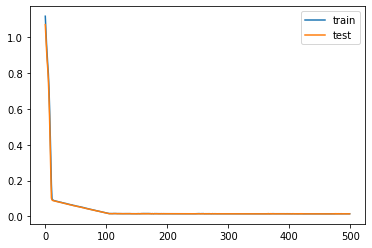

In [102]:
# design network
LSTM_model = Sequential()
LSTM_model.add(LSTM(5, input_shape=(train_input.shape[1], train_input.shape[2])))
LSTM_model.add(LeakyReLU(alpha=0.05))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mae', optimizer='adam')
# fit network
history = LSTM_model.fit(train_input, train_output, batch_size = 1, epochs = 500, validation_data = (train_input, train_output), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [103]:
LSTM_result = LSTM_model.predict(train_input)

In [104]:
LSTM_result_2001to2019 = LSTM_model.predict(train_input_2001to2019)

### Visualize: SPY -- with SPMC Data

In [105]:
visualize_spy(LSTM_result, SPMC_SPY_relative_price_benchmark.iloc[:-1])

,Prediction,Original
Date,,
2008-09-02,0.974648,1.000000
2008-09-03,0.975170,0.999141
2008-09-04,0.989650,0.969060
2008-09-05,0.989768,0.972107
2008-09-08,0.977934,0.992187
2008-09-09,0.974084,0.962731
2008-09-10,0.962225,0.966638
2008-09-11,0.948643,0.980624
2008-09-12,0.951464,0.985155


### Visualize: SPY -- with 2001-01-02 ~ 2019-7-17 data

In [106]:
visualize_spy(LSTM_result_2001to2019, SPY_relative_prices.iloc[:-1])

,Prediction,Original
Date,,
2001-01-02,0.974648,1.000000
2001-01-03,0.985124,1.048035
2001-01-04,0.986269,1.036754
2001-01-05,0.980953,1.002911
2001-01-08,0.976563,1.010674
2001-01-09,0.981378,1.008006
2001-01-10,0.980087,1.025715
2001-01-11,0.981279,1.026686
2001-01-12,0.977467,1.024745
